# M2177.003100 Deep Learning <br> Assignment #4 Implementing Conditional Generative Adversarial Nets - part3 Labeled MNIST

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Chaehun Shin, September 2020

In this notebook, you will learn how to implement conditional Genverative Adversarial Nets (cGANs) <br>
The goal here is to build GANs that draw hand-written digit image given its label. You can draw the digit 0~9 as you give an input at the end of training.<br>

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Student_ID** as input argument. <br>
This will produce a zipped file called *[Your Student_ID].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Student_ID#)

### Some helpful tutorials and references for assignment #4-3:
- [1] Pytorch official tutorials. [[link]](https://pytorch.org/tutorials/)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.
- [4] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).
- [5] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

## 0. Download and load MNIST datasets
The MNIST datasets will be downloaded into the 'data/mnist' directory. If you want to change the directory the data is saved in, change 'mnist_data_dir' with where you want. <br>

In [1]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as T

mnist_data_dir = './data/mnist'
dataset = MNIST(root=mnist_data_dir,
               transform=T.ToTensor(), train=True, download=True)
print(dataset.train_data.shape)
print(dataset.train_labels.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


/home/jaekyungcho/anaconda3/envs/deep-learning-20/lib/python3.8/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/jaekyungcho/anaconda3/envs/deep-learning-20/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## <a name="1"></a> 1. Building a network

In this section, you will implement neural networks for <br>
(1) generator model to draw a digit corresponding to given label<br>
(2) discriminator model to distinguish real images from generated images according to given labels.<br>
You can reuse your code in part2 and improve it. 
Just write the code in whatever way you find most clear.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

It is time for a generator model.
You can change anything including the argument if you need. Feel Free to change it and improve it.<br>
**(You should output the image as a range (0, 1) with Sigmoid function because we normalize the real images as a range (0, 1))**

In [3]:
class Conditional_Generator(nn.Module):
    def __init__(self, condition_dim=10, latent_dim=30, img_dim=1):
        super().__init__()
        ################ ToDo ################
        self.dconv_1_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=256,
                              kernel_size=4),
            nn.ReLU()
        )
        self.dconv_1_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=condition_dim, out_channels=256,
                              kernel_size=4), # 4X4 size
            nn.ReLU()
        )
        self.dconv_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256,
                              kernel_size=4,stride=2,padding=1), # 8X8 size
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.dconv_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256,out_channels=128,
                              kernel_size=4,stride=2,padding=2), # 16X16 size
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dconv_4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=1,
                              kernel_size=4,stride=2,padding=1), # 28X28 size
            nn.Sigmoid()
        )
        
    def forward(self, z, condition):
        ################ ToDo ################
        z = z.unsqueeze(dim=2).unsqueeze(dim=3)
        condition = condition.unsqueeze(dim=2).unsqueeze(dim=3)
        
        x = self.dconv_1_1(z)
        y = self.dconv_1_2(condition)
        x = torch.cat([x,y],dim=1) # dim 0 은 bacthsize이므로
        x = self.dconv_2(x)
        x = self.dconv_3(x)
        out = self.dconv_4(x).squeeze().unsqueeze(dim=1)
        

        return out

Now, it's time for a discriminative model. Again, you can change anything if you need.
**(You should output the probability of whether the input image of discriminator is real or not. It means that you use the Sigmoid function at the last layer to make the value being in range (0, 1))**

In [4]:
class Conditional_Discriminator(nn.Module):
    def __init__(self, condition_dim=10, img_dim=1):
        super().__init__()
        ################ ToDo ################
        self.conv_1_1 = nn.Sequential(
            nn.Conv2d(in_channels=img_dim, out_channels=64,
                     kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU()
        )
        self.conv_1_2 = nn.Sequential(
            nn.Conv2d(in_channels=condition_dim, out_channels=64,
                     kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,
                     kernel_size=4, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,
                     kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )
        self.conv_4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1,
                     kernel_size=4),
            nn.Sigmoid()
        )
        
        
        
    def forward(self, img, condition):
        ################ ToDo ################
        condition = condition.unsqueeze(dim=2).unsqueeze(dim=3)
        
        x = self.conv_1_1(img)
        y = self.conv_1_2(condition).expand(-1,-1,x.shape[2],x.shape[3])
        x = torch.cat([x,y],1) # dimension이 어떻게 되지
        x = self.conv_2(x)
        x = self.conv_3(x)
        out = self.conv_4(x).squeeze()
        

        return out
    

## <a name="2"></a> 2. Build a main part and train

In this section, you will implement the main part (define criterion variable and D_loss/G_loss to train in TODO parts, you can also use the criterion variable).
Feel free to set the hyperparmeters and fill in the main part.
When you are done, run the following to check your implementations.

Your goal is to **generate 10 row and 10 column images(100 total)**.<br>
**Each column should correspond to each label as an order**.<br>
You must show **at least three generated images** (At the beginning of , in the midway of, at the end of training).

In [5]:
# hyperparameter setting
img_dim=1
img_size = 28
latent_dim = 64
condition_dim=10

batch_size = 64
learning_rate = 1e-4
total_iter = 15000

log_freq = 10
viz_freq = 200

gen_num_samples = 100
gen_conditions = torch.tensor(list(range(10))*10)

Iter: 00010/15000, Gen loss: 4.2875, Dis loss: 0.0702
Iter: 00020/15000, Gen loss: 5.5252, Dis loss: 0.0196
Iter: 00030/15000, Gen loss: 6.5448, Dis loss: 0.0138
Iter: 00040/15000, Gen loss: 5.6273, Dis loss: 0.0186
Iter: 00050/15000, Gen loss: 6.9913, Dis loss: 0.0041
Iter: 00060/15000, Gen loss: 6.3672, Dis loss: 0.0123
Iter: 00070/15000, Gen loss: 7.0172, Dis loss: 0.0034
Iter: 00080/15000, Gen loss: 7.9946, Dis loss: 0.0022
Iter: 00090/15000, Gen loss: 6.4120, Dis loss: 0.0041
Iter: 00100/15000, Gen loss: 7.0565, Dis loss: 0.0067
Iter: 00110/15000, Gen loss: 7.1830, Dis loss: 0.0045
Iter: 00120/15000, Gen loss: 7.5434, Dis loss: 0.0044
Iter: 00130/15000, Gen loss: 8.5701, Dis loss: 0.0009
Iter: 00140/15000, Gen loss: 8.4529, Dis loss: 0.0012
Iter: 00150/15000, Gen loss: 8.2236, Dis loss: 0.0011
Iter: 00160/15000, Gen loss: 11.0793, Dis loss: 0.0116
Iter: 00170/15000, Gen loss: 10.9167, Dis loss: 0.0012
Iter: 00180/15000, Gen loss: 7.8246, Dis loss: 0.0113
Iter: 00190/15000, Gen los

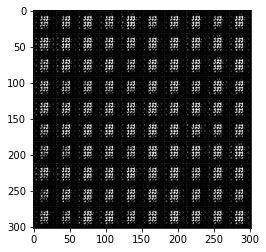

Iter: 00210/15000, Gen loss: 8.3785, Dis loss: 0.0916
Iter: 00220/15000, Gen loss: 9.5784, Dis loss: 0.0193
Iter: 00230/15000, Gen loss: 9.4789, Dis loss: 0.0085
Iter: 00240/15000, Gen loss: 6.8786, Dis loss: 0.0095
Iter: 00250/15000, Gen loss: 7.9196, Dis loss: 0.0279
Iter: 00260/15000, Gen loss: 7.6407, Dis loss: 0.0063
Iter: 00270/15000, Gen loss: 6.5873, Dis loss: 0.0906
Iter: 00280/15000, Gen loss: 8.3218, Dis loss: 0.0030
Iter: 00290/15000, Gen loss: 8.3670, Dis loss: 0.0076
Iter: 00300/15000, Gen loss: 6.9742, Dis loss: 0.0059
Iter: 00310/15000, Gen loss: 6.7267, Dis loss: 0.0066
Iter: 00320/15000, Gen loss: 7.3493, Dis loss: 0.0080
Iter: 00330/15000, Gen loss: 7.0706, Dis loss: 0.0042
Iter: 00340/15000, Gen loss: 7.2662, Dis loss: 0.0094
Iter: 00350/15000, Gen loss: 7.4382, Dis loss: 0.0041
Iter: 00360/15000, Gen loss: 7.0619, Dis loss: 0.0061
Iter: 00370/15000, Gen loss: 6.9251, Dis loss: 0.0029
Iter: 00380/15000, Gen loss: 7.4630, Dis loss: 0.0037
Iter: 00390/15000, Gen loss:

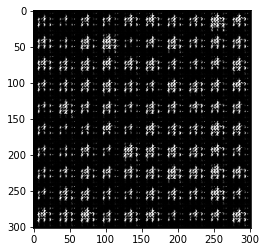

Iter: 00410/15000, Gen loss: 7.8268, Dis loss: 0.0026
Iter: 00420/15000, Gen loss: 7.0362, Dis loss: 0.0023
Iter: 00430/15000, Gen loss: 6.9140, Dis loss: 0.0036
Iter: 00440/15000, Gen loss: 6.2558, Dis loss: 0.0068
Iter: 00450/15000, Gen loss: 6.3737, Dis loss: 0.0086
Iter: 00460/15000, Gen loss: 7.2398, Dis loss: 0.0099
Iter: 00470/15000, Gen loss: 7.5969, Dis loss: 0.0093
Iter: 00480/15000, Gen loss: 8.2982, Dis loss: 0.0155
Iter: 00490/15000, Gen loss: 8.5824, Dis loss: 0.0031
Iter: 00500/15000, Gen loss: 7.1141, Dis loss: 0.0371
Iter: 00510/15000, Gen loss: 8.5619, Dis loss: 0.0104
Iter: 00520/15000, Gen loss: 9.2723, Dis loss: 0.0092
Iter: 00530/15000, Gen loss: 7.8865, Dis loss: 0.0131
Iter: 00540/15000, Gen loss: 12.0673, Dis loss: 0.0044
Iter: 00550/15000, Gen loss: 9.2368, Dis loss: 0.0245
Iter: 00560/15000, Gen loss: 9.0709, Dis loss: 0.0276
Iter: 00570/15000, Gen loss: 9.1499, Dis loss: 0.0133
Iter: 00580/15000, Gen loss: 7.5943, Dis loss: 0.0738
Iter: 00590/15000, Gen loss

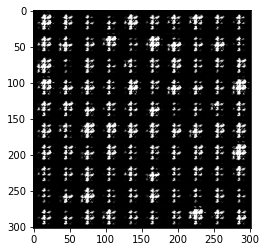

Iter: 00610/15000, Gen loss: 7.1194, Dis loss: 0.0067
Iter: 00620/15000, Gen loss: 6.4178, Dis loss: 0.0131
Iter: 00630/15000, Gen loss: 8.4842, Dis loss: 0.0114
Iter: 00640/15000, Gen loss: 9.0441, Dis loss: 0.0031
Iter: 00650/15000, Gen loss: 7.2405, Dis loss: 0.0083
Iter: 00660/15000, Gen loss: 7.3657, Dis loss: 0.0065
Iter: 00670/15000, Gen loss: 7.6815, Dis loss: 0.0022
Iter: 00680/15000, Gen loss: 10.2264, Dis loss: 0.0003
Iter: 00690/15000, Gen loss: 7.8231, Dis loss: 0.0021
Iter: 00700/15000, Gen loss: 7.4415, Dis loss: 0.0030
Iter: 00710/15000, Gen loss: 5.9465, Dis loss: 0.0058
Iter: 00720/15000, Gen loss: 6.9901, Dis loss: 0.0022
Iter: 00730/15000, Gen loss: 7.4700, Dis loss: 0.0134
Iter: 00740/15000, Gen loss: 7.5208, Dis loss: 0.0134
Iter: 00750/15000, Gen loss: 7.1288, Dis loss: 0.0069
Iter: 00760/15000, Gen loss: 9.3781, Dis loss: 0.0305
Iter: 00770/15000, Gen loss: 6.9493, Dis loss: 0.0813
Iter: 00780/15000, Gen loss: 8.6824, Dis loss: 0.0051
Iter: 00790/15000, Gen loss

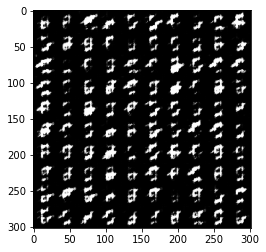

Iter: 00810/15000, Gen loss: 7.5440, Dis loss: 0.0584
Iter: 00820/15000, Gen loss: 11.3709, Dis loss: 0.0273
Iter: 00830/15000, Gen loss: 10.0572, Dis loss: 0.0035
Iter: 00840/15000, Gen loss: 6.3966, Dis loss: 0.0098
Iter: 00850/15000, Gen loss: 7.8747, Dis loss: 0.0088
Iter: 00860/15000, Gen loss: 7.4929, Dis loss: 0.0086
Iter: 00870/15000, Gen loss: 7.1371, Dis loss: 0.0356
Iter: 00880/15000, Gen loss: 7.6419, Dis loss: 0.0099
Iter: 00890/15000, Gen loss: 6.9026, Dis loss: 0.0199
Iter: 00900/15000, Gen loss: 6.9175, Dis loss: 0.0282
Iter: 00910/15000, Gen loss: 9.0706, Dis loss: 0.0022
Iter: 00920/15000, Gen loss: 7.8521, Dis loss: 0.0066
Iter: 00930/15000, Gen loss: 8.1381, Dis loss: 0.0107
Iter: 00940/15000, Gen loss: 8.2235, Dis loss: 0.0068
Iter: 00950/15000, Gen loss: 7.1084, Dis loss: 0.0182
Iter: 00960/15000, Gen loss: 7.4690, Dis loss: 0.0312
Iter: 00970/15000, Gen loss: 6.4160, Dis loss: 0.0061
Iter: 00980/15000, Gen loss: 6.5582, Dis loss: 0.0184
Iter: 00990/15000, Gen los

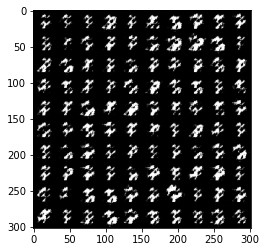

Iter: 01010/15000, Gen loss: 9.4418, Dis loss: 0.0038
Iter: 01020/15000, Gen loss: 7.0098, Dis loss: 0.0087
Iter: 01030/15000, Gen loss: 6.8228, Dis loss: 0.0094
Iter: 01040/15000, Gen loss: 6.1076, Dis loss: 0.0050
Iter: 01050/15000, Gen loss: 7.4771, Dis loss: 0.0043
Iter: 01060/15000, Gen loss: 10.0175, Dis loss: 0.0090
Iter: 01070/15000, Gen loss: 9.6746, Dis loss: 0.0030
Iter: 01080/15000, Gen loss: 4.2492, Dis loss: 0.3224
Iter: 01090/15000, Gen loss: 5.2257, Dis loss: 0.1891
Iter: 01100/15000, Gen loss: 11.3556, Dis loss: 0.0279
Iter: 01110/15000, Gen loss: 6.3960, Dis loss: 0.0392
Iter: 01120/15000, Gen loss: 5.7751, Dis loss: 0.1561
Iter: 01130/15000, Gen loss: 4.1127, Dis loss: 0.1300
Iter: 01140/15000, Gen loss: 4.7683, Dis loss: 0.0677
Iter: 01150/15000, Gen loss: 6.3148, Dis loss: 0.0390
Iter: 01160/15000, Gen loss: 6.4000, Dis loss: 0.0641
Iter: 01170/15000, Gen loss: 5.8050, Dis loss: 0.0303
Iter: 01180/15000, Gen loss: 5.3850, Dis loss: 0.1138
Iter: 01190/15000, Gen los

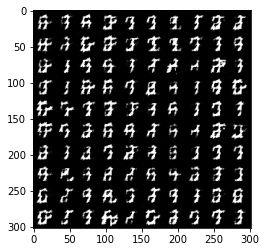

Iter: 01210/15000, Gen loss: 6.1003, Dis loss: 0.0193
Iter: 01220/15000, Gen loss: 5.6858, Dis loss: 0.0208
Iter: 01230/15000, Gen loss: 6.7297, Dis loss: 0.0334
Iter: 01240/15000, Gen loss: 6.9888, Dis loss: 0.0106
Iter: 01250/15000, Gen loss: 5.7641, Dis loss: 0.0125
Iter: 01260/15000, Gen loss: 5.6048, Dis loss: 0.0337
Iter: 01270/15000, Gen loss: 6.5919, Dis loss: 0.0281
Iter: 01280/15000, Gen loss: 6.2042, Dis loss: 0.0116
Iter: 01290/15000, Gen loss: 6.0740, Dis loss: 0.0286
Iter: 01300/15000, Gen loss: 6.0716, Dis loss: 0.0147
Iter: 01310/15000, Gen loss: 7.5810, Dis loss: 0.0049
Iter: 01320/15000, Gen loss: 6.0418, Dis loss: 0.0072
Iter: 01330/15000, Gen loss: 5.9592, Dis loss: 0.0137
Iter: 01340/15000, Gen loss: 4.9247, Dis loss: 0.0201
Iter: 01350/15000, Gen loss: 5.8495, Dis loss: 0.0353
Iter: 01360/15000, Gen loss: 6.6243, Dis loss: 0.0104
Iter: 01370/15000, Gen loss: 7.2970, Dis loss: 0.0070
Iter: 01380/15000, Gen loss: 6.4235, Dis loss: 0.0146
Iter: 01390/15000, Gen loss:

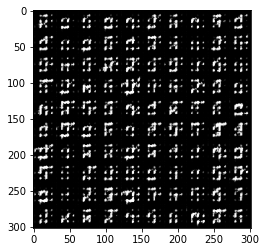

Iter: 01410/15000, Gen loss: 6.3815, Dis loss: 0.0107
Iter: 01420/15000, Gen loss: 6.3438, Dis loss: 0.0082
Iter: 01430/15000, Gen loss: 6.3822, Dis loss: 0.0121
Iter: 01440/15000, Gen loss: 6.2584, Dis loss: 0.0094
Iter: 01450/15000, Gen loss: 5.9984, Dis loss: 0.0117
Iter: 01460/15000, Gen loss: 6.8742, Dis loss: 0.0156
Iter: 01470/15000, Gen loss: 6.3791, Dis loss: 0.0160
Iter: 01480/15000, Gen loss: 5.2472, Dis loss: 0.0484
Iter: 01490/15000, Gen loss: 5.3373, Dis loss: 0.0114
Iter: 01500/15000, Gen loss: 7.0853, Dis loss: 0.0118
Iter: 01510/15000, Gen loss: 8.2014, Dis loss: 0.0056
Iter: 01520/15000, Gen loss: 7.3499, Dis loss: 0.0036
Iter: 01530/15000, Gen loss: 6.2669, Dis loss: 0.0213
Iter: 01540/15000, Gen loss: 5.6002, Dis loss: 0.0177
Iter: 01550/15000, Gen loss: 7.1376, Dis loss: 0.0287
Iter: 01560/15000, Gen loss: 6.5289, Dis loss: 0.0103
Iter: 01570/15000, Gen loss: 6.0753, Dis loss: 0.0154
Iter: 01580/15000, Gen loss: 6.6116, Dis loss: 0.0473
Iter: 01590/15000, Gen loss:

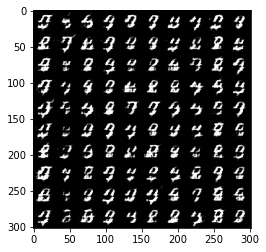

Iter: 01610/15000, Gen loss: 7.0718, Dis loss: 0.0142
Iter: 01620/15000, Gen loss: 7.1161, Dis loss: 0.0265
Iter: 01630/15000, Gen loss: 5.9115, Dis loss: 0.0088
Iter: 01640/15000, Gen loss: 5.4016, Dis loss: 0.0234
Iter: 01650/15000, Gen loss: 6.0709, Dis loss: 0.0110
Iter: 01660/15000, Gen loss: 6.0311, Dis loss: 0.0123
Iter: 01670/15000, Gen loss: 7.1000, Dis loss: 0.0132
Iter: 01680/15000, Gen loss: 5.0662, Dis loss: 0.0763
Iter: 01690/15000, Gen loss: 6.7505, Dis loss: 0.0627
Iter: 01700/15000, Gen loss: 7.3851, Dis loss: 0.0167
Iter: 01710/15000, Gen loss: 6.7515, Dis loss: 0.0124
Iter: 01720/15000, Gen loss: 7.5648, Dis loss: 0.0248
Iter: 01730/15000, Gen loss: 7.5374, Dis loss: 0.0092
Iter: 01740/15000, Gen loss: 7.5202, Dis loss: 0.0220
Iter: 01750/15000, Gen loss: 5.4545, Dis loss: 0.0685
Iter: 01760/15000, Gen loss: 8.2620, Dis loss: 0.0129
Iter: 01770/15000, Gen loss: 8.3117, Dis loss: 0.0027
Iter: 01780/15000, Gen loss: 6.7814, Dis loss: 0.0053
Iter: 01790/15000, Gen loss:

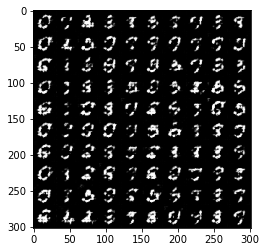

Iter: 01810/15000, Gen loss: 6.7480, Dis loss: 0.0166
Iter: 01820/15000, Gen loss: 5.0467, Dis loss: 0.0168
Iter: 01830/15000, Gen loss: 7.5390, Dis loss: 0.0103
Iter: 01840/15000, Gen loss: 9.9342, Dis loss: 0.0105
Iter: 01850/15000, Gen loss: 9.5774, Dis loss: 0.0059
Iter: 01860/15000, Gen loss: 5.1230, Dis loss: 0.1459
Iter: 01870/15000, Gen loss: 8.1354, Dis loss: 0.0231
Iter: 01880/15000, Gen loss: 7.8333, Dis loss: 0.0122
Iter: 01890/15000, Gen loss: 6.4540, Dis loss: 0.0380
Iter: 01900/15000, Gen loss: 9.2840, Dis loss: 0.0358
Iter: 01910/15000, Gen loss: 8.7050, Dis loss: 0.0181
Iter: 01920/15000, Gen loss: 5.3995, Dis loss: 0.0576
Iter: 01930/15000, Gen loss: 6.8243, Dis loss: 0.0598
Iter: 01940/15000, Gen loss: 6.7353, Dis loss: 0.0363
Iter: 01950/15000, Gen loss: 5.5480, Dis loss: 0.0259
Iter: 01960/15000, Gen loss: 3.4981, Dis loss: 0.1520
Iter: 01970/15000, Gen loss: 8.3507, Dis loss: 0.0057
Iter: 01980/15000, Gen loss: 5.1582, Dis loss: 0.0242
Iter: 01990/15000, Gen loss:

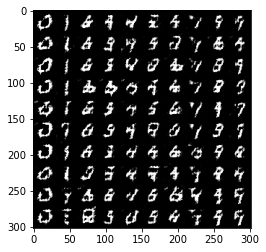

Iter: 02010/15000, Gen loss: 6.0405, Dis loss: 0.0871
Iter: 02020/15000, Gen loss: 5.7518, Dis loss: 0.1295
Iter: 02030/15000, Gen loss: 7.6268, Dis loss: 0.0298
Iter: 02040/15000, Gen loss: 8.1322, Dis loss: 0.0420
Iter: 02050/15000, Gen loss: 7.4713, Dis loss: 0.0585
Iter: 02060/15000, Gen loss: 5.6108, Dis loss: 0.0591
Iter: 02070/15000, Gen loss: 6.7202, Dis loss: 0.0328
Iter: 02080/15000, Gen loss: 9.7296, Dis loss: 0.0041
Iter: 02090/15000, Gen loss: 9.0349, Dis loss: 0.0056
Iter: 02100/15000, Gen loss: 6.4531, Dis loss: 0.0299
Iter: 02110/15000, Gen loss: 5.8908, Dis loss: 0.0440
Iter: 02120/15000, Gen loss: 6.5584, Dis loss: 0.0286
Iter: 02130/15000, Gen loss: 5.8384, Dis loss: 0.0683
Iter: 02140/15000, Gen loss: 6.0823, Dis loss: 0.0245
Iter: 02150/15000, Gen loss: 5.4533, Dis loss: 0.0209
Iter: 02160/15000, Gen loss: 7.3346, Dis loss: 0.0952
Iter: 02170/15000, Gen loss: 6.9332, Dis loss: 0.0491
Iter: 02180/15000, Gen loss: 4.7659, Dis loss: 0.0483
Iter: 02190/15000, Gen loss:

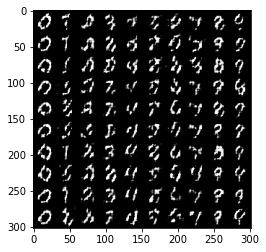

Iter: 02210/15000, Gen loss: 7.8507, Dis loss: 0.0368
Iter: 02220/15000, Gen loss: 6.2767, Dis loss: 0.0215
Iter: 02230/15000, Gen loss: 4.4321, Dis loss: 0.1210
Iter: 02240/15000, Gen loss: 5.1628, Dis loss: 0.1665
Iter: 02250/15000, Gen loss: 4.0102, Dis loss: 0.2020
Iter: 02260/15000, Gen loss: 5.2809, Dis loss: 0.1094
Iter: 02270/15000, Gen loss: 6.2743, Dis loss: 0.0225
Iter: 02280/15000, Gen loss: 5.1336, Dis loss: 0.1102
Iter: 02290/15000, Gen loss: 4.9113, Dis loss: 0.1837
Iter: 02300/15000, Gen loss: 6.6130, Dis loss: 0.0206
Iter: 02310/15000, Gen loss: 6.7611, Dis loss: 0.1669
Iter: 02320/15000, Gen loss: 6.2629, Dis loss: 0.0865
Iter: 02330/15000, Gen loss: 3.9019, Dis loss: 0.1633
Iter: 02340/15000, Gen loss: 6.2229, Dis loss: 0.0399
Iter: 02350/15000, Gen loss: 4.8653, Dis loss: 0.1722
Iter: 02360/15000, Gen loss: 6.5263, Dis loss: 0.0450
Iter: 02370/15000, Gen loss: 1.7412, Dis loss: 0.1092
Iter: 02380/15000, Gen loss: 2.8647, Dis loss: 0.0781
Iter: 02390/15000, Gen loss:

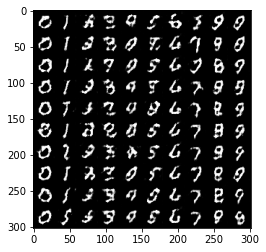

Iter: 02410/15000, Gen loss: 4.8421, Dis loss: 0.1489
Iter: 02420/15000, Gen loss: 5.8239, Dis loss: 0.1680
Iter: 02430/15000, Gen loss: 3.5872, Dis loss: 0.3167
Iter: 02440/15000, Gen loss: 5.1445, Dis loss: 0.0625
Iter: 02450/15000, Gen loss: 5.3023, Dis loss: 0.1655
Iter: 02460/15000, Gen loss: 5.2762, Dis loss: 0.0710
Iter: 02470/15000, Gen loss: 4.9056, Dis loss: 0.0460
Iter: 02480/15000, Gen loss: 3.8992, Dis loss: 0.0899
Iter: 02490/15000, Gen loss: 4.0894, Dis loss: 0.1091
Iter: 02500/15000, Gen loss: 5.7826, Dis loss: 0.3059
Iter: 02510/15000, Gen loss: 3.8216, Dis loss: 0.1058
Iter: 02520/15000, Gen loss: 5.6570, Dis loss: 0.1235
Iter: 02530/15000, Gen loss: 3.6182, Dis loss: 0.0879
Iter: 02540/15000, Gen loss: 6.0808, Dis loss: 0.1769
Iter: 02550/15000, Gen loss: 4.2148, Dis loss: 0.1470
Iter: 02560/15000, Gen loss: 4.0923, Dis loss: 0.1507
Iter: 02570/15000, Gen loss: 3.8196, Dis loss: 0.2811
Iter: 02580/15000, Gen loss: 3.1489, Dis loss: 0.1788
Iter: 02590/15000, Gen loss:

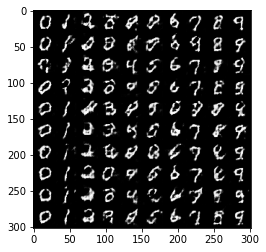

Iter: 02610/15000, Gen loss: 4.0945, Dis loss: 0.1977
Iter: 02620/15000, Gen loss: 4.3486, Dis loss: 0.2227
Iter: 02630/15000, Gen loss: 3.8316, Dis loss: 0.1397
Iter: 02640/15000, Gen loss: 6.5609, Dis loss: 0.1200
Iter: 02650/15000, Gen loss: 5.0312, Dis loss: 0.0624
Iter: 02660/15000, Gen loss: 5.1197, Dis loss: 0.1105
Iter: 02670/15000, Gen loss: 4.3288, Dis loss: 0.1851
Iter: 02680/15000, Gen loss: 4.9467, Dis loss: 0.1220
Iter: 02690/15000, Gen loss: 4.8678, Dis loss: 0.2262
Iter: 02700/15000, Gen loss: 3.3296, Dis loss: 0.1088
Iter: 02710/15000, Gen loss: 5.5317, Dis loss: 0.0960
Iter: 02720/15000, Gen loss: 3.0790, Dis loss: 0.0789
Iter: 02730/15000, Gen loss: 6.4958, Dis loss: 0.0853
Iter: 02740/15000, Gen loss: 4.4509, Dis loss: 0.0979
Iter: 02750/15000, Gen loss: 3.9418, Dis loss: 0.2416
Iter: 02760/15000, Gen loss: 5.4043, Dis loss: 0.2548
Iter: 02770/15000, Gen loss: 7.6478, Dis loss: 0.0430
Iter: 02780/15000, Gen loss: 4.7298, Dis loss: 0.0681
Iter: 02790/15000, Gen loss:

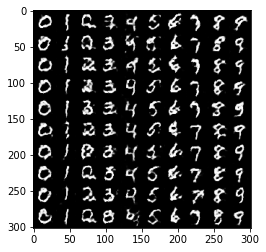

Iter: 02810/15000, Gen loss: 4.6973, Dis loss: 0.1253
Iter: 02820/15000, Gen loss: 3.2814, Dis loss: 0.1752
Iter: 02830/15000, Gen loss: 4.1422, Dis loss: 0.3960
Iter: 02840/15000, Gen loss: 4.7637, Dis loss: 0.1632
Iter: 02850/15000, Gen loss: 4.9998, Dis loss: 0.2350
Iter: 02860/15000, Gen loss: 3.9352, Dis loss: 0.0803
Iter: 02870/15000, Gen loss: 4.3316, Dis loss: 0.1430
Iter: 02880/15000, Gen loss: 4.7563, Dis loss: 0.0828
Iter: 02890/15000, Gen loss: 5.1473, Dis loss: 0.0672
Iter: 02900/15000, Gen loss: 3.2030, Dis loss: 0.1605
Iter: 02910/15000, Gen loss: 5.8254, Dis loss: 0.1298
Iter: 02920/15000, Gen loss: 3.8867, Dis loss: 0.1341
Iter: 02930/15000, Gen loss: 4.5820, Dis loss: 0.2248
Iter: 02940/15000, Gen loss: 5.3607, Dis loss: 0.2524
Iter: 02950/15000, Gen loss: 3.1627, Dis loss: 0.2107
Iter: 02960/15000, Gen loss: 5.9173, Dis loss: 0.0288
Iter: 02970/15000, Gen loss: 5.4984, Dis loss: 0.2081
Iter: 02980/15000, Gen loss: 3.8267, Dis loss: 0.2689
Iter: 02990/15000, Gen loss:

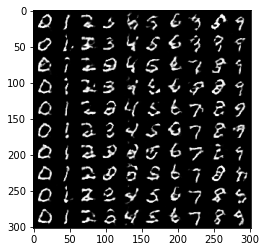

Iter: 03010/15000, Gen loss: 3.5186, Dis loss: 0.3158
Iter: 03020/15000, Gen loss: 5.1842, Dis loss: 0.2500
Iter: 03030/15000, Gen loss: 4.0585, Dis loss: 0.1533
Iter: 03040/15000, Gen loss: 4.8498, Dis loss: 0.0485
Iter: 03050/15000, Gen loss: 4.8441, Dis loss: 0.1643
Iter: 03060/15000, Gen loss: 2.5547, Dis loss: 0.3608
Iter: 03070/15000, Gen loss: 6.1578, Dis loss: 0.1933
Iter: 03080/15000, Gen loss: 5.0290, Dis loss: 0.2391
Iter: 03090/15000, Gen loss: 4.4780, Dis loss: 0.1169
Iter: 03100/15000, Gen loss: 3.9336, Dis loss: 0.1945
Iter: 03110/15000, Gen loss: 5.6088, Dis loss: 0.1479
Iter: 03120/15000, Gen loss: 4.4551, Dis loss: 0.1311
Iter: 03130/15000, Gen loss: 5.6023, Dis loss: 0.4598
Iter: 03140/15000, Gen loss: 4.0787, Dis loss: 0.1558
Iter: 03150/15000, Gen loss: 3.5327, Dis loss: 0.1374
Iter: 03160/15000, Gen loss: 4.0272, Dis loss: 0.3328
Iter: 03170/15000, Gen loss: 4.8505, Dis loss: 0.1292
Iter: 03180/15000, Gen loss: 5.2603, Dis loss: 0.0693
Iter: 03190/15000, Gen loss:

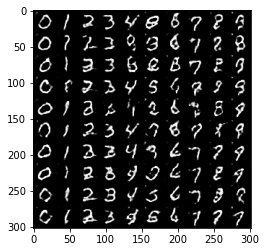

Iter: 03210/15000, Gen loss: 2.0970, Dis loss: 0.4534
Iter: 03220/15000, Gen loss: 3.9242, Dis loss: 0.3004
Iter: 03230/15000, Gen loss: 4.0672, Dis loss: 0.3977
Iter: 03240/15000, Gen loss: 3.3153, Dis loss: 0.6280
Iter: 03250/15000, Gen loss: 3.7336, Dis loss: 0.1533
Iter: 03260/15000, Gen loss: 4.2128, Dis loss: 0.2634
Iter: 03270/15000, Gen loss: 3.3233, Dis loss: 0.2125
Iter: 03280/15000, Gen loss: 2.1807, Dis loss: 0.1884
Iter: 03290/15000, Gen loss: 3.8550, Dis loss: 0.1485
Iter: 03300/15000, Gen loss: 2.7248, Dis loss: 0.3128
Iter: 03310/15000, Gen loss: 3.6457, Dis loss: 0.2426
Iter: 03320/15000, Gen loss: 3.0370, Dis loss: 0.1859
Iter: 03330/15000, Gen loss: 4.8300, Dis loss: 0.1734
Iter: 03340/15000, Gen loss: 2.4671, Dis loss: 0.1650
Iter: 03350/15000, Gen loss: 4.0295, Dis loss: 0.2000
Iter: 03360/15000, Gen loss: 4.7026, Dis loss: 0.3309
Iter: 03370/15000, Gen loss: 4.1843, Dis loss: 0.2075
Iter: 03380/15000, Gen loss: 4.1740, Dis loss: 0.2530
Iter: 03390/15000, Gen loss:

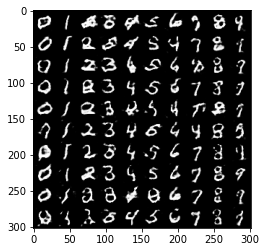

Iter: 03410/15000, Gen loss: 3.2313, Dis loss: 0.2096
Iter: 03420/15000, Gen loss: 7.0131, Dis loss: 0.1517
Iter: 03430/15000, Gen loss: 4.1563, Dis loss: 0.1735
Iter: 03440/15000, Gen loss: 4.0458, Dis loss: 0.1917
Iter: 03450/15000, Gen loss: 3.1124, Dis loss: 0.3459
Iter: 03460/15000, Gen loss: 4.2261, Dis loss: 0.1296
Iter: 03470/15000, Gen loss: 3.0652, Dis loss: 0.2045
Iter: 03480/15000, Gen loss: 3.3153, Dis loss: 0.4053
Iter: 03490/15000, Gen loss: 6.4239, Dis loss: 0.1850
Iter: 03500/15000, Gen loss: 4.9358, Dis loss: 0.1502
Iter: 03510/15000, Gen loss: 5.0063, Dis loss: 0.1946
Iter: 03520/15000, Gen loss: 2.7823, Dis loss: 0.2284
Iter: 03530/15000, Gen loss: 2.8446, Dis loss: 0.3358
Iter: 03540/15000, Gen loss: 3.0919, Dis loss: 0.2641
Iter: 03550/15000, Gen loss: 3.3087, Dis loss: 0.3792
Iter: 03560/15000, Gen loss: 3.8966, Dis loss: 0.2402
Iter: 03570/15000, Gen loss: 1.5771, Dis loss: 0.3100
Iter: 03580/15000, Gen loss: 4.5332, Dis loss: 0.2360
Iter: 03590/15000, Gen loss:

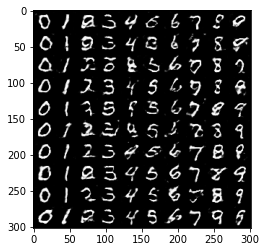

Iter: 03610/15000, Gen loss: 3.9905, Dis loss: 0.2165
Iter: 03620/15000, Gen loss: 2.5610, Dis loss: 0.1359
Iter: 03630/15000, Gen loss: 4.4091, Dis loss: 0.3106
Iter: 03640/15000, Gen loss: 3.0977, Dis loss: 0.2183
Iter: 03650/15000, Gen loss: 3.9583, Dis loss: 0.3795
Iter: 03660/15000, Gen loss: 2.0250, Dis loss: 0.4008
Iter: 03670/15000, Gen loss: 4.0892, Dis loss: 0.2733
Iter: 03680/15000, Gen loss: 4.8988, Dis loss: 0.2377
Iter: 03690/15000, Gen loss: 4.7022, Dis loss: 0.5494
Iter: 03700/15000, Gen loss: 3.0576, Dis loss: 0.3010
Iter: 03710/15000, Gen loss: 3.3536, Dis loss: 0.4059
Iter: 03720/15000, Gen loss: 4.7920, Dis loss: 1.1647
Iter: 03730/15000, Gen loss: 1.6641, Dis loss: 0.3434
Iter: 03740/15000, Gen loss: 2.7134, Dis loss: 0.2526
Iter: 03750/15000, Gen loss: 5.5155, Dis loss: 0.3338
Iter: 03760/15000, Gen loss: 3.3551, Dis loss: 0.1355
Iter: 03770/15000, Gen loss: 2.6655, Dis loss: 0.2020
Iter: 03780/15000, Gen loss: 2.5810, Dis loss: 0.2010
Iter: 03790/15000, Gen loss:

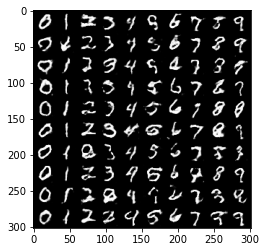

Iter: 03810/15000, Gen loss: 3.6551, Dis loss: 1.0745
Iter: 03820/15000, Gen loss: 3.4266, Dis loss: 0.2978
Iter: 03830/15000, Gen loss: 3.7976, Dis loss: 0.3756
Iter: 03840/15000, Gen loss: 3.8653, Dis loss: 0.2861
Iter: 03850/15000, Gen loss: 2.4038, Dis loss: 0.2563
Iter: 03860/15000, Gen loss: 5.1860, Dis loss: 0.2675
Iter: 03870/15000, Gen loss: 3.9390, Dis loss: 0.1941
Iter: 03880/15000, Gen loss: 3.2417, Dis loss: 0.2075
Iter: 03890/15000, Gen loss: 2.5752, Dis loss: 0.4152
Iter: 03900/15000, Gen loss: 2.2581, Dis loss: 0.3581
Iter: 03910/15000, Gen loss: 5.0893, Dis loss: 0.2745
Iter: 03920/15000, Gen loss: 2.4514, Dis loss: 0.3169
Iter: 03930/15000, Gen loss: 2.6712, Dis loss: 0.4500
Iter: 03940/15000, Gen loss: 3.8853, Dis loss: 0.4198
Iter: 03950/15000, Gen loss: 4.6062, Dis loss: 0.2280
Iter: 03960/15000, Gen loss: 3.4784, Dis loss: 0.4628
Iter: 03970/15000, Gen loss: 3.5869, Dis loss: 0.3154
Iter: 03980/15000, Gen loss: 3.0934, Dis loss: 0.5015
Iter: 03990/15000, Gen loss:

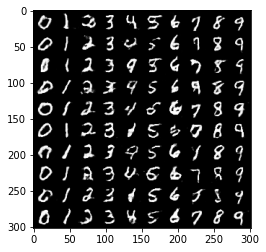

Iter: 04010/15000, Gen loss: 2.0678, Dis loss: 0.1984
Iter: 04020/15000, Gen loss: 3.7361, Dis loss: 0.5159
Iter: 04030/15000, Gen loss: 2.2972, Dis loss: 0.8207
Iter: 04040/15000, Gen loss: 3.4270, Dis loss: 0.3066
Iter: 04050/15000, Gen loss: 2.5358, Dis loss: 0.4630
Iter: 04060/15000, Gen loss: 3.9182, Dis loss: 0.3624
Iter: 04070/15000, Gen loss: 1.5755, Dis loss: 0.3208
Iter: 04080/15000, Gen loss: 2.6976, Dis loss: 0.5273
Iter: 04090/15000, Gen loss: 3.8077, Dis loss: 0.2977
Iter: 04100/15000, Gen loss: 1.9504, Dis loss: 0.4039
Iter: 04110/15000, Gen loss: 2.1688, Dis loss: 0.5840
Iter: 04120/15000, Gen loss: 2.9660, Dis loss: 0.4256
Iter: 04130/15000, Gen loss: 3.4775, Dis loss: 0.8586
Iter: 04140/15000, Gen loss: 2.5546, Dis loss: 1.0405
Iter: 04150/15000, Gen loss: 4.5114, Dis loss: 1.2217
Iter: 04160/15000, Gen loss: 1.6958, Dis loss: 0.4967
Iter: 04170/15000, Gen loss: 1.8549, Dis loss: 0.4316
Iter: 04180/15000, Gen loss: 2.8846, Dis loss: 0.3552
Iter: 04190/15000, Gen loss:

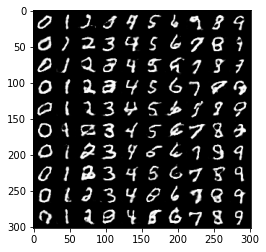

Iter: 04210/15000, Gen loss: 2.7890, Dis loss: 0.6764
Iter: 04220/15000, Gen loss: 3.0331, Dis loss: 0.3506
Iter: 04230/15000, Gen loss: 1.5231, Dis loss: 0.3908
Iter: 04240/15000, Gen loss: 2.9030, Dis loss: 0.4376
Iter: 04250/15000, Gen loss: 3.1637, Dis loss: 0.5001
Iter: 04260/15000, Gen loss: 2.8641, Dis loss: 0.2814
Iter: 04270/15000, Gen loss: 3.6400, Dis loss: 0.3960
Iter: 04280/15000, Gen loss: 2.0525, Dis loss: 0.3419
Iter: 04290/15000, Gen loss: 1.5481, Dis loss: 0.3467
Iter: 04300/15000, Gen loss: 1.8152, Dis loss: 0.3477
Iter: 04310/15000, Gen loss: 2.3266, Dis loss: 0.6055
Iter: 04320/15000, Gen loss: 2.4941, Dis loss: 0.4011
Iter: 04330/15000, Gen loss: 1.3500, Dis loss: 0.3981
Iter: 04340/15000, Gen loss: 2.5383, Dis loss: 0.4373
Iter: 04350/15000, Gen loss: 2.0862, Dis loss: 0.6376
Iter: 04360/15000, Gen loss: 1.9031, Dis loss: 0.3758
Iter: 04370/15000, Gen loss: 1.6478, Dis loss: 1.1412
Iter: 04380/15000, Gen loss: 3.7355, Dis loss: 1.0420
Iter: 04390/15000, Gen loss:

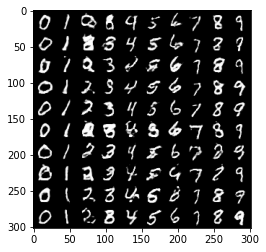

Iter: 04410/15000, Gen loss: 2.3813, Dis loss: 0.5848
Iter: 04420/15000, Gen loss: 2.1830, Dis loss: 0.5325
Iter: 04430/15000, Gen loss: 3.8404, Dis loss: 0.5060
Iter: 04440/15000, Gen loss: 3.2124, Dis loss: 0.5849
Iter: 04450/15000, Gen loss: 2.4208, Dis loss: 0.3091
Iter: 04460/15000, Gen loss: 3.7450, Dis loss: 0.6060
Iter: 04470/15000, Gen loss: 3.3448, Dis loss: 0.5854
Iter: 04480/15000, Gen loss: 1.7741, Dis loss: 0.7462
Iter: 04490/15000, Gen loss: 2.6409, Dis loss: 0.4325
Iter: 04500/15000, Gen loss: 3.1841, Dis loss: 0.6231
Iter: 04510/15000, Gen loss: 1.7207, Dis loss: 0.3892
Iter: 04520/15000, Gen loss: 2.2744, Dis loss: 0.5766
Iter: 04530/15000, Gen loss: 1.8575, Dis loss: 0.4991
Iter: 04540/15000, Gen loss: 2.2367, Dis loss: 0.3567
Iter: 04550/15000, Gen loss: 3.0783, Dis loss: 0.6265
Iter: 04560/15000, Gen loss: 3.4962, Dis loss: 0.9311
Iter: 04570/15000, Gen loss: 1.0505, Dis loss: 0.7108
Iter: 04580/15000, Gen loss: 3.1699, Dis loss: 0.6480
Iter: 04590/15000, Gen loss:

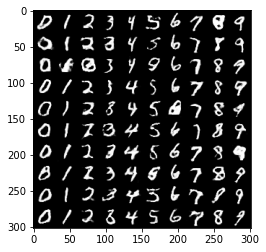

Iter: 04610/15000, Gen loss: 2.1863, Dis loss: 0.3691
Iter: 04620/15000, Gen loss: 3.4244, Dis loss: 0.6238
Iter: 04630/15000, Gen loss: 1.9718, Dis loss: 0.8254
Iter: 04640/15000, Gen loss: 3.0205, Dis loss: 0.7943
Iter: 04650/15000, Gen loss: 3.0093, Dis loss: 0.9540
Iter: 04660/15000, Gen loss: 1.3485, Dis loss: 0.5621
Iter: 04670/15000, Gen loss: 3.4487, Dis loss: 0.5187
Iter: 04680/15000, Gen loss: 1.8465, Dis loss: 0.5837
Iter: 04690/15000, Gen loss: 1.9127, Dis loss: 0.3137
Iter: 04700/15000, Gen loss: 1.9573, Dis loss: 1.0561
Iter: 04710/15000, Gen loss: 1.4867, Dis loss: 0.7115
Iter: 04720/15000, Gen loss: 3.5789, Dis loss: 0.4381
Iter: 04730/15000, Gen loss: 2.2488, Dis loss: 0.3939
Iter: 04740/15000, Gen loss: 2.6364, Dis loss: 0.6676
Iter: 04750/15000, Gen loss: 2.6079, Dis loss: 0.4607
Iter: 04760/15000, Gen loss: 3.0654, Dis loss: 0.6105
Iter: 04770/15000, Gen loss: 2.0819, Dis loss: 0.5532
Iter: 04780/15000, Gen loss: 2.9513, Dis loss: 0.4341
Iter: 04790/15000, Gen loss:

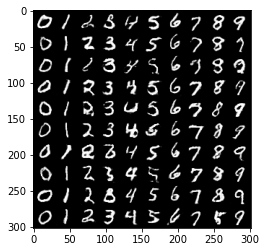

Iter: 04810/15000, Gen loss: 3.5516, Dis loss: 0.9827
Iter: 04820/15000, Gen loss: 1.9193, Dis loss: 0.4954
Iter: 04830/15000, Gen loss: 1.7305, Dis loss: 0.7748
Iter: 04840/15000, Gen loss: 1.0998, Dis loss: 0.8873
Iter: 04850/15000, Gen loss: 2.4061, Dis loss: 0.6353
Iter: 04860/15000, Gen loss: 2.0362, Dis loss: 0.6668
Iter: 04870/15000, Gen loss: 1.6784, Dis loss: 0.5898
Iter: 04880/15000, Gen loss: 2.8336, Dis loss: 0.6824
Iter: 04890/15000, Gen loss: 1.4746, Dis loss: 0.8284
Iter: 04900/15000, Gen loss: 1.0148, Dis loss: 0.8079
Iter: 04910/15000, Gen loss: 1.3709, Dis loss: 0.6076
Iter: 04920/15000, Gen loss: 2.2341, Dis loss: 0.7773
Iter: 04930/15000, Gen loss: 2.2843, Dis loss: 0.8548
Iter: 04940/15000, Gen loss: 2.0316, Dis loss: 0.7216
Iter: 04950/15000, Gen loss: 2.7282, Dis loss: 0.4076
Iter: 04960/15000, Gen loss: 1.1980, Dis loss: 0.4954
Iter: 04970/15000, Gen loss: 1.5960, Dis loss: 1.5133
Iter: 04980/15000, Gen loss: 1.8324, Dis loss: 0.6707
Iter: 04990/15000, Gen loss:

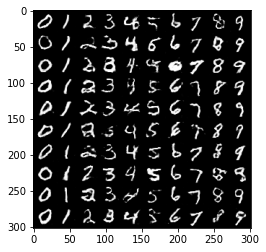

Iter: 05010/15000, Gen loss: 2.6654, Dis loss: 0.8400
Iter: 05020/15000, Gen loss: 1.6925, Dis loss: 0.5173
Iter: 05030/15000, Gen loss: 2.5750, Dis loss: 0.5949
Iter: 05040/15000, Gen loss: 1.5776, Dis loss: 1.1473
Iter: 05050/15000, Gen loss: 1.8388, Dis loss: 0.6154
Iter: 05060/15000, Gen loss: 3.4951, Dis loss: 1.1739
Iter: 05070/15000, Gen loss: 1.5791, Dis loss: 0.6735
Iter: 05080/15000, Gen loss: 2.2871, Dis loss: 0.6938
Iter: 05090/15000, Gen loss: 1.7397, Dis loss: 0.5106
Iter: 05100/15000, Gen loss: 2.3731, Dis loss: 0.4988
Iter: 05110/15000, Gen loss: 2.2031, Dis loss: 0.7069
Iter: 05120/15000, Gen loss: 2.8467, Dis loss: 0.9292
Iter: 05130/15000, Gen loss: 2.4326, Dis loss: 0.6956
Iter: 05140/15000, Gen loss: 1.5694, Dis loss: 0.7567
Iter: 05150/15000, Gen loss: 1.9738, Dis loss: 0.4547
Iter: 05160/15000, Gen loss: 1.5743, Dis loss: 0.8028
Iter: 05170/15000, Gen loss: 3.2916, Dis loss: 0.6266
Iter: 05180/15000, Gen loss: 1.0988, Dis loss: 0.6606
Iter: 05190/15000, Gen loss:

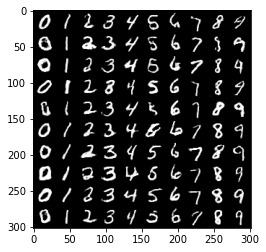

Iter: 05210/15000, Gen loss: 2.5133, Dis loss: 0.6112
Iter: 05220/15000, Gen loss: 1.8666, Dis loss: 0.8557
Iter: 05230/15000, Gen loss: 0.9007, Dis loss: 0.4120
Iter: 05240/15000, Gen loss: 0.6094, Dis loss: 1.0851
Iter: 05250/15000, Gen loss: 1.7438, Dis loss: 1.0291
Iter: 05260/15000, Gen loss: 1.3700, Dis loss: 1.1105
Iter: 05270/15000, Gen loss: 2.0209, Dis loss: 0.6489
Iter: 05280/15000, Gen loss: 2.5435, Dis loss: 0.7472
Iter: 05290/15000, Gen loss: 3.3598, Dis loss: 0.7801
Iter: 05300/15000, Gen loss: 1.5972, Dis loss: 1.0068
Iter: 05310/15000, Gen loss: 1.9113, Dis loss: 0.4944
Iter: 05320/15000, Gen loss: 0.6979, Dis loss: 1.1258
Iter: 05330/15000, Gen loss: 1.1545, Dis loss: 0.8784
Iter: 05340/15000, Gen loss: 2.4554, Dis loss: 0.4885
Iter: 05350/15000, Gen loss: 1.6913, Dis loss: 0.6947
Iter: 05360/15000, Gen loss: 3.0890, Dis loss: 0.7247
Iter: 05370/15000, Gen loss: 2.1082, Dis loss: 0.5119
Iter: 05380/15000, Gen loss: 2.0820, Dis loss: 0.8105
Iter: 05390/15000, Gen loss:

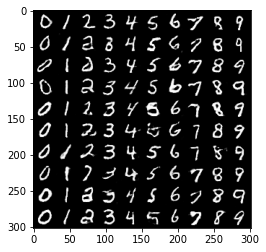

Iter: 05410/15000, Gen loss: 2.3324, Dis loss: 0.8527
Iter: 05420/15000, Gen loss: 2.7137, Dis loss: 0.7027
Iter: 05430/15000, Gen loss: 2.2929, Dis loss: 1.1288
Iter: 05440/15000, Gen loss: 1.7647, Dis loss: 0.7667
Iter: 05450/15000, Gen loss: 1.7622, Dis loss: 0.8513
Iter: 05460/15000, Gen loss: 1.9236, Dis loss: 0.5553
Iter: 05470/15000, Gen loss: 2.5915, Dis loss: 0.5631
Iter: 05480/15000, Gen loss: 1.1297, Dis loss: 1.0203
Iter: 05490/15000, Gen loss: 0.7994, Dis loss: 0.8128
Iter: 05500/15000, Gen loss: 0.7449, Dis loss: 0.6622
Iter: 05510/15000, Gen loss: 1.5484, Dis loss: 0.6901
Iter: 05520/15000, Gen loss: 1.8127, Dis loss: 0.5478
Iter: 05530/15000, Gen loss: 1.9154, Dis loss: 0.7811
Iter: 05540/15000, Gen loss: 1.2155, Dis loss: 0.6414
Iter: 05550/15000, Gen loss: 2.1550, Dis loss: 0.6472
Iter: 05560/15000, Gen loss: 3.0435, Dis loss: 0.6336
Iter: 05570/15000, Gen loss: 1.2557, Dis loss: 0.5411
Iter: 05580/15000, Gen loss: 1.4238, Dis loss: 0.7210
Iter: 05590/15000, Gen loss:

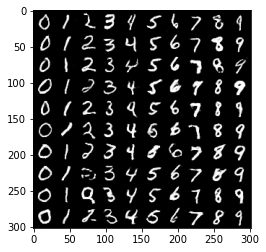

Iter: 05610/15000, Gen loss: 2.7047, Dis loss: 0.9766
Iter: 05620/15000, Gen loss: 1.3077, Dis loss: 0.7033
Iter: 05630/15000, Gen loss: 1.1450, Dis loss: 0.5280
Iter: 05640/15000, Gen loss: 2.1155, Dis loss: 0.9517
Iter: 05650/15000, Gen loss: 2.4653, Dis loss: 0.6461
Iter: 05660/15000, Gen loss: 1.9792, Dis loss: 0.9527
Iter: 05670/15000, Gen loss: 1.9722, Dis loss: 0.5891
Iter: 05680/15000, Gen loss: 1.3037, Dis loss: 0.5822
Iter: 05690/15000, Gen loss: 1.2890, Dis loss: 0.6844
Iter: 05700/15000, Gen loss: 1.9563, Dis loss: 0.4851
Iter: 05710/15000, Gen loss: 1.6673, Dis loss: 0.7623
Iter: 05720/15000, Gen loss: 1.8915, Dis loss: 0.5217
Iter: 05730/15000, Gen loss: 2.7434, Dis loss: 0.6083
Iter: 05740/15000, Gen loss: 2.0442, Dis loss: 0.7234
Iter: 05750/15000, Gen loss: 1.2492, Dis loss: 0.5816
Iter: 05760/15000, Gen loss: 1.1092, Dis loss: 0.7797
Iter: 05770/15000, Gen loss: 3.1706, Dis loss: 0.6072
Iter: 05780/15000, Gen loss: 0.7706, Dis loss: 0.8130
Iter: 05790/15000, Gen loss:

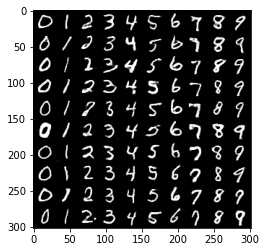

Iter: 05810/15000, Gen loss: 2.8003, Dis loss: 0.5890
Iter: 05820/15000, Gen loss: 1.7703, Dis loss: 0.6003
Iter: 05830/15000, Gen loss: 1.2292, Dis loss: 1.0821
Iter: 05840/15000, Gen loss: 2.7301, Dis loss: 0.5888
Iter: 05850/15000, Gen loss: 2.9877, Dis loss: 0.5069
Iter: 05860/15000, Gen loss: 1.5133, Dis loss: 0.7863
Iter: 05870/15000, Gen loss: 2.2547, Dis loss: 1.0857
Iter: 05880/15000, Gen loss: 1.6096, Dis loss: 0.4609
Iter: 05890/15000, Gen loss: 2.4686, Dis loss: 0.5416
Iter: 05900/15000, Gen loss: 1.3114, Dis loss: 0.6645
Iter: 05910/15000, Gen loss: 1.1431, Dis loss: 0.8090
Iter: 05920/15000, Gen loss: 1.1778, Dis loss: 0.6507
Iter: 05930/15000, Gen loss: 2.2053, Dis loss: 0.6006
Iter: 05940/15000, Gen loss: 1.9101, Dis loss: 0.9012
Iter: 05950/15000, Gen loss: 2.2033, Dis loss: 0.7712
Iter: 05960/15000, Gen loss: 1.1761, Dis loss: 0.8080
Iter: 05970/15000, Gen loss: 1.3389, Dis loss: 0.6662
Iter: 05980/15000, Gen loss: 2.0470, Dis loss: 0.5696
Iter: 05990/15000, Gen loss:

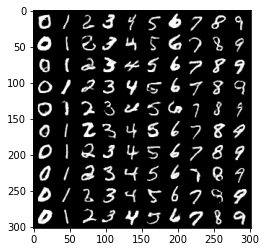

Iter: 06010/15000, Gen loss: 2.0873, Dis loss: 0.6256
Iter: 06020/15000, Gen loss: 1.1548, Dis loss: 0.3917
Iter: 06030/15000, Gen loss: 2.3031, Dis loss: 0.9187
Iter: 06040/15000, Gen loss: 1.9085, Dis loss: 0.8571
Iter: 06050/15000, Gen loss: 1.8462, Dis loss: 0.7445
Iter: 06060/15000, Gen loss: 3.0783, Dis loss: 0.9613
Iter: 06070/15000, Gen loss: 1.8713, Dis loss: 0.8196
Iter: 06080/15000, Gen loss: 1.7119, Dis loss: 1.0277
Iter: 06090/15000, Gen loss: 2.2952, Dis loss: 0.4379
Iter: 06100/15000, Gen loss: 1.9640, Dis loss: 0.4153
Iter: 06110/15000, Gen loss: 2.3159, Dis loss: 1.2515
Iter: 06120/15000, Gen loss: 1.4739, Dis loss: 0.9280
Iter: 06130/15000, Gen loss: 2.1401, Dis loss: 0.8087
Iter: 06140/15000, Gen loss: 1.6363, Dis loss: 0.7827
Iter: 06150/15000, Gen loss: 1.2675, Dis loss: 0.6188
Iter: 06160/15000, Gen loss: 2.2171, Dis loss: 0.7430
Iter: 06170/15000, Gen loss: 2.0724, Dis loss: 0.7050
Iter: 06180/15000, Gen loss: 1.5369, Dis loss: 0.4843
Iter: 06190/15000, Gen loss:

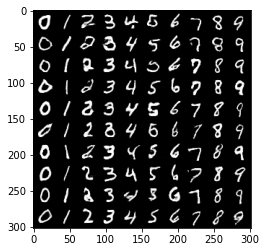

Iter: 06210/15000, Gen loss: 1.7316, Dis loss: 1.1614
Iter: 06220/15000, Gen loss: 1.5335, Dis loss: 1.0903
Iter: 06230/15000, Gen loss: 1.6876, Dis loss: 0.7956
Iter: 06240/15000, Gen loss: 1.6737, Dis loss: 0.8129
Iter: 06250/15000, Gen loss: 1.9271, Dis loss: 1.0145
Iter: 06260/15000, Gen loss: 1.8113, Dis loss: 1.2815
Iter: 06270/15000, Gen loss: 3.1577, Dis loss: 0.8832
Iter: 06280/15000, Gen loss: 0.5614, Dis loss: 1.0338
Iter: 06290/15000, Gen loss: 2.2788, Dis loss: 0.8976
Iter: 06300/15000, Gen loss: 1.6617, Dis loss: 0.7342
Iter: 06310/15000, Gen loss: 1.7075, Dis loss: 0.5447
Iter: 06320/15000, Gen loss: 1.1227, Dis loss: 0.5267
Iter: 06330/15000, Gen loss: 1.5597, Dis loss: 0.8640
Iter: 06340/15000, Gen loss: 1.6625, Dis loss: 0.6484
Iter: 06350/15000, Gen loss: 2.7051, Dis loss: 0.7990
Iter: 06360/15000, Gen loss: 1.3595, Dis loss: 1.2524
Iter: 06370/15000, Gen loss: 2.6624, Dis loss: 0.7868
Iter: 06380/15000, Gen loss: 1.2270, Dis loss: 0.8013
Iter: 06390/15000, Gen loss:

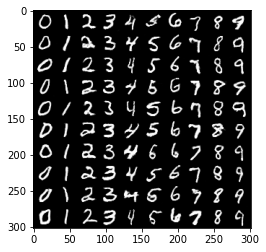

Iter: 06410/15000, Gen loss: 0.8652, Dis loss: 1.0238
Iter: 06420/15000, Gen loss: 0.8174, Dis loss: 0.8187
Iter: 06430/15000, Gen loss: 2.3727, Dis loss: 0.3698
Iter: 06440/15000, Gen loss: 1.6642, Dis loss: 1.2451
Iter: 06450/15000, Gen loss: 0.9547, Dis loss: 1.2447
Iter: 06460/15000, Gen loss: 2.3205, Dis loss: 1.0551
Iter: 06470/15000, Gen loss: 1.7576, Dis loss: 0.8081
Iter: 06480/15000, Gen loss: 1.1579, Dis loss: 0.9461
Iter: 06490/15000, Gen loss: 1.1994, Dis loss: 0.5794
Iter: 06500/15000, Gen loss: 1.4300, Dis loss: 0.8352
Iter: 06510/15000, Gen loss: 2.2766, Dis loss: 0.7179
Iter: 06520/15000, Gen loss: 1.3682, Dis loss: 0.4502
Iter: 06530/15000, Gen loss: 2.2689, Dis loss: 1.3705
Iter: 06540/15000, Gen loss: 1.4824, Dis loss: 0.9403
Iter: 06550/15000, Gen loss: 2.3682, Dis loss: 0.5578
Iter: 06560/15000, Gen loss: 1.6324, Dis loss: 0.5904
Iter: 06570/15000, Gen loss: 1.9783, Dis loss: 0.6382
Iter: 06580/15000, Gen loss: 1.5030, Dis loss: 1.2210
Iter: 06590/15000, Gen loss:

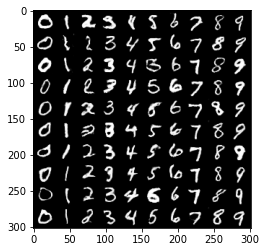

Iter: 06610/15000, Gen loss: 0.6849, Dis loss: 0.6565
Iter: 06620/15000, Gen loss: 2.9415, Dis loss: 0.9738
Iter: 06630/15000, Gen loss: 0.8771, Dis loss: 1.0702
Iter: 06640/15000, Gen loss: 0.5147, Dis loss: 0.7721
Iter: 06650/15000, Gen loss: 1.6561, Dis loss: 0.6990
Iter: 06660/15000, Gen loss: 1.1691, Dis loss: 0.6054
Iter: 06670/15000, Gen loss: 2.1833, Dis loss: 0.7806
Iter: 06680/15000, Gen loss: 1.1531, Dis loss: 1.2042
Iter: 06690/15000, Gen loss: 1.4085, Dis loss: 0.6458
Iter: 06700/15000, Gen loss: 2.0753, Dis loss: 0.4731
Iter: 06710/15000, Gen loss: 0.6142, Dis loss: 0.7236
Iter: 06720/15000, Gen loss: 0.7374, Dis loss: 1.4546
Iter: 06730/15000, Gen loss: 1.8079, Dis loss: 0.7168
Iter: 06740/15000, Gen loss: 0.9376, Dis loss: 0.8231
Iter: 06750/15000, Gen loss: 1.3652, Dis loss: 0.9605
Iter: 06760/15000, Gen loss: 2.1794, Dis loss: 0.8006
Iter: 06770/15000, Gen loss: 2.0170, Dis loss: 0.7663
Iter: 06780/15000, Gen loss: 2.8017, Dis loss: 1.0608
Iter: 06790/15000, Gen loss:

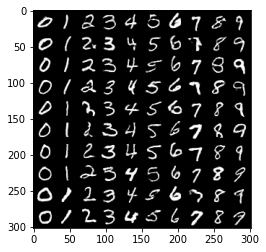

Iter: 06810/15000, Gen loss: 0.5394, Dis loss: 0.9053
Iter: 06820/15000, Gen loss: 0.6659, Dis loss: 0.7007
Iter: 06830/15000, Gen loss: 1.2045, Dis loss: 0.6729
Iter: 06840/15000, Gen loss: 0.8788, Dis loss: 1.4962
Iter: 06850/15000, Gen loss: 1.2281, Dis loss: 0.7193
Iter: 06860/15000, Gen loss: 2.0278, Dis loss: 0.8335
Iter: 06870/15000, Gen loss: 1.6998, Dis loss: 0.9917
Iter: 06880/15000, Gen loss: 0.8420, Dis loss: 0.8595
Iter: 06890/15000, Gen loss: 1.3371, Dis loss: 0.9417
Iter: 06900/15000, Gen loss: 1.4943, Dis loss: 1.4264
Iter: 06910/15000, Gen loss: 0.8288, Dis loss: 0.9861
Iter: 06920/15000, Gen loss: 1.1933, Dis loss: 0.8335
Iter: 06930/15000, Gen loss: 0.9496, Dis loss: 0.9447
Iter: 06940/15000, Gen loss: 0.8246, Dis loss: 1.1026
Iter: 06950/15000, Gen loss: 1.4811, Dis loss: 0.8895
Iter: 06960/15000, Gen loss: 1.6100, Dis loss: 0.6718
Iter: 06970/15000, Gen loss: 1.5869, Dis loss: 0.6917
Iter: 06980/15000, Gen loss: 1.7079, Dis loss: 0.7501
Iter: 06990/15000, Gen loss:

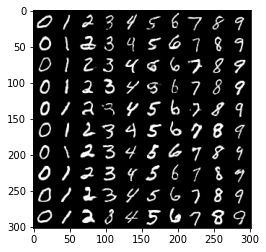

Iter: 07010/15000, Gen loss: 1.2312, Dis loss: 0.8927
Iter: 07020/15000, Gen loss: 1.0508, Dis loss: 0.6333
Iter: 07030/15000, Gen loss: 1.3784, Dis loss: 0.6430
Iter: 07040/15000, Gen loss: 1.7426, Dis loss: 1.2596
Iter: 07050/15000, Gen loss: 1.1013, Dis loss: 0.9405
Iter: 07060/15000, Gen loss: 2.1336, Dis loss: 0.6553
Iter: 07070/15000, Gen loss: 2.5592, Dis loss: 0.5225
Iter: 07080/15000, Gen loss: 1.4167, Dis loss: 0.8190
Iter: 07090/15000, Gen loss: 1.6019, Dis loss: 0.8360
Iter: 07100/15000, Gen loss: 2.1361, Dis loss: 1.0624
Iter: 07110/15000, Gen loss: 2.5081, Dis loss: 1.2456
Iter: 07120/15000, Gen loss: 2.7665, Dis loss: 1.3293
Iter: 07130/15000, Gen loss: 2.9404, Dis loss: 0.6334
Iter: 07140/15000, Gen loss: 1.0160, Dis loss: 0.9765
Iter: 07150/15000, Gen loss: 2.2377, Dis loss: 0.7233
Iter: 07160/15000, Gen loss: 1.6834, Dis loss: 0.5042
Iter: 07170/15000, Gen loss: 1.3327, Dis loss: 1.1635
Iter: 07180/15000, Gen loss: 1.7532, Dis loss: 0.9258
Iter: 07190/15000, Gen loss:

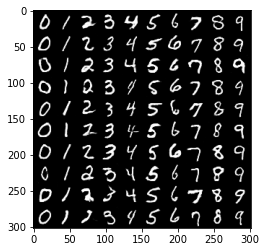

Iter: 07210/15000, Gen loss: 1.6525, Dis loss: 0.6675
Iter: 07220/15000, Gen loss: 0.8768, Dis loss: 0.8257
Iter: 07230/15000, Gen loss: 1.6297, Dis loss: 0.8426
Iter: 07240/15000, Gen loss: 1.3907, Dis loss: 0.6596
Iter: 07250/15000, Gen loss: 0.9955, Dis loss: 1.2997
Iter: 07260/15000, Gen loss: 1.9701, Dis loss: 1.1966
Iter: 07270/15000, Gen loss: 1.8515, Dis loss: 1.2541
Iter: 07280/15000, Gen loss: 1.6703, Dis loss: 0.8110
Iter: 07290/15000, Gen loss: 1.4402, Dis loss: 1.1985
Iter: 07300/15000, Gen loss: 1.5414, Dis loss: 0.5892
Iter: 07310/15000, Gen loss: 1.2782, Dis loss: 1.1793
Iter: 07320/15000, Gen loss: 1.6172, Dis loss: 0.5679
Iter: 07330/15000, Gen loss: 1.7408, Dis loss: 1.2979
Iter: 07340/15000, Gen loss: 1.0066, Dis loss: 0.8481
Iter: 07350/15000, Gen loss: 1.2348, Dis loss: 0.9155
Iter: 07360/15000, Gen loss: 1.9712, Dis loss: 0.9129
Iter: 07370/15000, Gen loss: 2.4244, Dis loss: 0.7374
Iter: 07380/15000, Gen loss: 1.3300, Dis loss: 0.7919
Iter: 07390/15000, Gen loss:

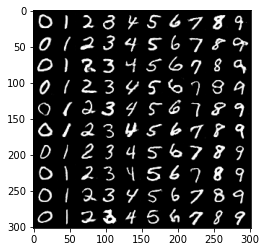

Iter: 07410/15000, Gen loss: 1.2888, Dis loss: 0.9471
Iter: 07420/15000, Gen loss: 1.7590, Dis loss: 0.9638
Iter: 07430/15000, Gen loss: 1.2928, Dis loss: 0.9028
Iter: 07440/15000, Gen loss: 1.7129, Dis loss: 0.6253
Iter: 07450/15000, Gen loss: 1.4519, Dis loss: 0.8542
Iter: 07460/15000, Gen loss: 2.9620, Dis loss: 0.8535
Iter: 07470/15000, Gen loss: 2.3602, Dis loss: 0.6536
Iter: 07480/15000, Gen loss: 1.1010, Dis loss: 0.6962
Iter: 07490/15000, Gen loss: 0.8006, Dis loss: 0.6301
Iter: 07500/15000, Gen loss: 2.0222, Dis loss: 1.3476
Iter: 07510/15000, Gen loss: 1.4671, Dis loss: 0.8394
Iter: 07520/15000, Gen loss: 2.0645, Dis loss: 0.8757
Iter: 07530/15000, Gen loss: 1.2708, Dis loss: 0.6974
Iter: 07540/15000, Gen loss: 1.3816, Dis loss: 0.8199
Iter: 07550/15000, Gen loss: 1.8441, Dis loss: 0.8810
Iter: 07560/15000, Gen loss: 1.4976, Dis loss: 1.0312
Iter: 07570/15000, Gen loss: 1.3535, Dis loss: 0.7283
Iter: 07580/15000, Gen loss: 1.3162, Dis loss: 0.9451
Iter: 07590/15000, Gen loss:

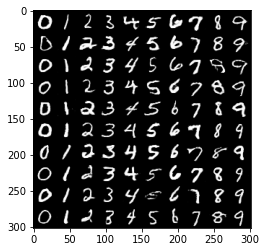

Iter: 07610/15000, Gen loss: 3.2146, Dis loss: 0.8017
Iter: 07620/15000, Gen loss: 1.1365, Dis loss: 1.5820
Iter: 07630/15000, Gen loss: 3.4125, Dis loss: 0.8274
Iter: 07640/15000, Gen loss: 1.9863, Dis loss: 0.7996
Iter: 07650/15000, Gen loss: 1.9201, Dis loss: 0.5511
Iter: 07660/15000, Gen loss: 1.7312, Dis loss: 0.6734
Iter: 07670/15000, Gen loss: 1.8253, Dis loss: 0.9664
Iter: 07680/15000, Gen loss: 1.1880, Dis loss: 0.9333
Iter: 07690/15000, Gen loss: 0.5061, Dis loss: 1.0644
Iter: 07700/15000, Gen loss: 1.3780, Dis loss: 0.9783
Iter: 07710/15000, Gen loss: 1.8433, Dis loss: 0.6958
Iter: 07720/15000, Gen loss: 1.5648, Dis loss: 0.6728
Iter: 07730/15000, Gen loss: 1.4154, Dis loss: 0.9363
Iter: 07740/15000, Gen loss: 1.5686, Dis loss: 1.2367
Iter: 07750/15000, Gen loss: 1.9408, Dis loss: 1.1042
Iter: 07760/15000, Gen loss: 1.5062, Dis loss: 0.9506
Iter: 07770/15000, Gen loss: 1.9301, Dis loss: 0.7210
Iter: 07780/15000, Gen loss: 2.9294, Dis loss: 0.8485
Iter: 07790/15000, Gen loss:

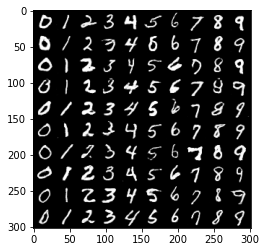

Iter: 07810/15000, Gen loss: 0.9291, Dis loss: 0.6916
Iter: 07820/15000, Gen loss: 0.6859, Dis loss: 0.7397
Iter: 07830/15000, Gen loss: 2.7713, Dis loss: 0.8096
Iter: 07840/15000, Gen loss: 1.0357, Dis loss: 0.7339
Iter: 07850/15000, Gen loss: 3.1965, Dis loss: 1.0913
Iter: 07860/15000, Gen loss: 1.3549, Dis loss: 1.0178
Iter: 07870/15000, Gen loss: 1.7017, Dis loss: 0.9294
Iter: 07880/15000, Gen loss: 1.5634, Dis loss: 0.6983
Iter: 07890/15000, Gen loss: 0.8630, Dis loss: 0.7518
Iter: 07900/15000, Gen loss: 0.9894, Dis loss: 0.8084
Iter: 07910/15000, Gen loss: 1.3416, Dis loss: 0.6583
Iter: 07920/15000, Gen loss: 0.8004, Dis loss: 0.8634
Iter: 07930/15000, Gen loss: 1.2713, Dis loss: 1.0541
Iter: 07940/15000, Gen loss: 1.6515, Dis loss: 0.7108
Iter: 07950/15000, Gen loss: 1.4228, Dis loss: 1.2032
Iter: 07960/15000, Gen loss: 0.8740, Dis loss: 0.7094
Iter: 07970/15000, Gen loss: 0.7359, Dis loss: 0.8154
Iter: 07980/15000, Gen loss: 1.0811, Dis loss: 0.7420
Iter: 07990/15000, Gen loss:

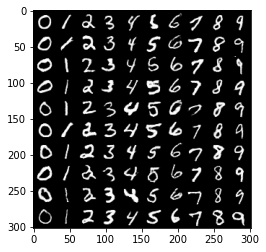

Iter: 08010/15000, Gen loss: 2.4601, Dis loss: 0.9770
Iter: 08020/15000, Gen loss: 1.1273, Dis loss: 1.0648
Iter: 08030/15000, Gen loss: 1.5692, Dis loss: 1.0032
Iter: 08040/15000, Gen loss: 1.1477, Dis loss: 1.2302
Iter: 08050/15000, Gen loss: 1.3450, Dis loss: 0.8481
Iter: 08060/15000, Gen loss: 0.7036, Dis loss: 1.1496
Iter: 08070/15000, Gen loss: 1.4354, Dis loss: 0.9241
Iter: 08080/15000, Gen loss: 1.3490, Dis loss: 0.8493
Iter: 08090/15000, Gen loss: 1.3568, Dis loss: 0.6460
Iter: 08100/15000, Gen loss: 1.9278, Dis loss: 0.7947
Iter: 08110/15000, Gen loss: 0.9807, Dis loss: 1.0883
Iter: 08120/15000, Gen loss: 1.2490, Dis loss: 1.0750
Iter: 08130/15000, Gen loss: 1.7194, Dis loss: 0.7217
Iter: 08140/15000, Gen loss: 1.3312, Dis loss: 0.9426
Iter: 08150/15000, Gen loss: 0.8785, Dis loss: 1.1717
Iter: 08160/15000, Gen loss: 2.0833, Dis loss: 0.8311
Iter: 08170/15000, Gen loss: 1.1204, Dis loss: 1.1084
Iter: 08180/15000, Gen loss: 1.2244, Dis loss: 0.9832
Iter: 08190/15000, Gen loss:

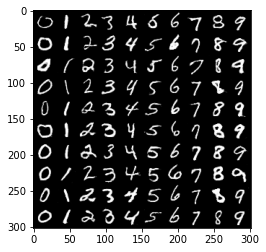

Iter: 08210/15000, Gen loss: 1.8276, Dis loss: 0.8894
Iter: 08220/15000, Gen loss: 2.5206, Dis loss: 0.8073
Iter: 08230/15000, Gen loss: 1.3201, Dis loss: 1.2761
Iter: 08240/15000, Gen loss: 2.3121, Dis loss: 1.0506
Iter: 08250/15000, Gen loss: 2.0679, Dis loss: 0.6565
Iter: 08260/15000, Gen loss: 0.9055, Dis loss: 0.8708
Iter: 08270/15000, Gen loss: 0.8256, Dis loss: 0.7533
Iter: 08280/15000, Gen loss: 1.3678, Dis loss: 0.8729
Iter: 08290/15000, Gen loss: 1.3595, Dis loss: 1.0586
Iter: 08300/15000, Gen loss: 0.6783, Dis loss: 0.9434
Iter: 08310/15000, Gen loss: 1.9067, Dis loss: 1.0245
Iter: 08320/15000, Gen loss: 1.8185, Dis loss: 1.5677
Iter: 08330/15000, Gen loss: 1.6995, Dis loss: 1.1040
Iter: 08340/15000, Gen loss: 0.6471, Dis loss: 0.7914
Iter: 08350/15000, Gen loss: 1.3281, Dis loss: 0.8003
Iter: 08360/15000, Gen loss: 1.4820, Dis loss: 0.6386
Iter: 08370/15000, Gen loss: 1.3218, Dis loss: 0.9898
Iter: 08380/15000, Gen loss: 1.4116, Dis loss: 0.6565
Iter: 08390/15000, Gen loss:

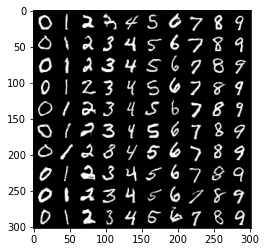

Iter: 08410/15000, Gen loss: 1.1896, Dis loss: 1.0136
Iter: 08420/15000, Gen loss: 0.9176, Dis loss: 0.7311
Iter: 08430/15000, Gen loss: 0.8673, Dis loss: 0.9121
Iter: 08440/15000, Gen loss: 2.0379, Dis loss: 0.8391
Iter: 08450/15000, Gen loss: 1.8237, Dis loss: 0.7268
Iter: 08460/15000, Gen loss: 1.6923, Dis loss: 0.5707
Iter: 08470/15000, Gen loss: 2.0256, Dis loss: 0.9094
Iter: 08480/15000, Gen loss: 1.5702, Dis loss: 1.0431
Iter: 08490/15000, Gen loss: 2.1111, Dis loss: 0.9477
Iter: 08500/15000, Gen loss: 2.1755, Dis loss: 0.9641
Iter: 08510/15000, Gen loss: 1.2703, Dis loss: 0.8946
Iter: 08520/15000, Gen loss: 2.8396, Dis loss: 0.9077
Iter: 08530/15000, Gen loss: 1.4546, Dis loss: 0.8555
Iter: 08540/15000, Gen loss: 1.3303, Dis loss: 0.9931
Iter: 08550/15000, Gen loss: 1.7416, Dis loss: 0.8544
Iter: 08560/15000, Gen loss: 1.9602, Dis loss: 0.7862
Iter: 08570/15000, Gen loss: 1.1368, Dis loss: 0.7129
Iter: 08580/15000, Gen loss: 1.7239, Dis loss: 1.0002
Iter: 08590/15000, Gen loss:

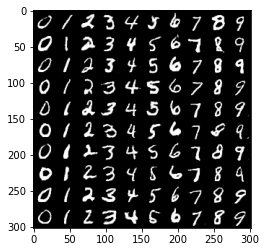

Iter: 08610/15000, Gen loss: 2.3347, Dis loss: 0.7561
Iter: 08620/15000, Gen loss: 1.6862, Dis loss: 0.7303
Iter: 08630/15000, Gen loss: 2.1136, Dis loss: 1.1361
Iter: 08640/15000, Gen loss: 2.3073, Dis loss: 1.3975
Iter: 08650/15000, Gen loss: 2.0444, Dis loss: 0.7218
Iter: 08660/15000, Gen loss: 1.3502, Dis loss: 0.7361
Iter: 08670/15000, Gen loss: 2.1595, Dis loss: 0.8783
Iter: 08680/15000, Gen loss: 1.2578, Dis loss: 0.7804
Iter: 08690/15000, Gen loss: 1.8187, Dis loss: 0.5974
Iter: 08700/15000, Gen loss: 1.2570, Dis loss: 0.8696
Iter: 08710/15000, Gen loss: 2.3219, Dis loss: 0.9005
Iter: 08720/15000, Gen loss: 1.8909, Dis loss: 0.8640
Iter: 08730/15000, Gen loss: 1.6060, Dis loss: 1.0109
Iter: 08740/15000, Gen loss: 0.8968, Dis loss: 0.7246
Iter: 08750/15000, Gen loss: 1.6435, Dis loss: 0.8412
Iter: 08760/15000, Gen loss: 1.0271, Dis loss: 1.0012
Iter: 08770/15000, Gen loss: 1.8032, Dis loss: 0.5393
Iter: 08780/15000, Gen loss: 1.9947, Dis loss: 0.6764
Iter: 08790/15000, Gen loss:

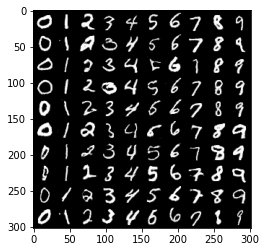

Iter: 08810/15000, Gen loss: 0.8801, Dis loss: 0.9466
Iter: 08820/15000, Gen loss: 2.0453, Dis loss: 0.9077
Iter: 08830/15000, Gen loss: 1.4402, Dis loss: 0.9019
Iter: 08840/15000, Gen loss: 1.8524, Dis loss: 0.8025
Iter: 08850/15000, Gen loss: 0.8633, Dis loss: 0.9646
Iter: 08860/15000, Gen loss: 2.2510, Dis loss: 0.8555
Iter: 08870/15000, Gen loss: 2.3746, Dis loss: 0.9859
Iter: 08880/15000, Gen loss: 1.7420, Dis loss: 0.7674
Iter: 08890/15000, Gen loss: 1.9655, Dis loss: 1.0946
Iter: 08900/15000, Gen loss: 1.7211, Dis loss: 0.9433
Iter: 08910/15000, Gen loss: 1.9964, Dis loss: 1.0910
Iter: 08920/15000, Gen loss: 1.3874, Dis loss: 0.5560
Iter: 08930/15000, Gen loss: 1.6352, Dis loss: 1.0335
Iter: 08940/15000, Gen loss: 1.0480, Dis loss: 1.0931
Iter: 08950/15000, Gen loss: 1.5456, Dis loss: 1.2173
Iter: 08960/15000, Gen loss: 1.3315, Dis loss: 1.2366
Iter: 08970/15000, Gen loss: 0.9531, Dis loss: 0.7832
Iter: 08980/15000, Gen loss: 1.0995, Dis loss: 0.7941
Iter: 08990/15000, Gen loss:

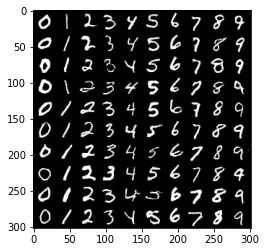

Iter: 09010/15000, Gen loss: 2.6701, Dis loss: 1.0296
Iter: 09020/15000, Gen loss: 1.0446, Dis loss: 0.7692
Iter: 09030/15000, Gen loss: 1.7080, Dis loss: 0.6765
Iter: 09040/15000, Gen loss: 2.2526, Dis loss: 0.8617
Iter: 09050/15000, Gen loss: 1.2132, Dis loss: 0.7665
Iter: 09060/15000, Gen loss: 1.3821, Dis loss: 0.7599
Iter: 09070/15000, Gen loss: 1.7654, Dis loss: 0.9456
Iter: 09080/15000, Gen loss: 0.9517, Dis loss: 0.7052
Iter: 09090/15000, Gen loss: 0.8698, Dis loss: 1.1352
Iter: 09100/15000, Gen loss: 2.0221, Dis loss: 1.0696
Iter: 09110/15000, Gen loss: 1.8943, Dis loss: 1.0535
Iter: 09120/15000, Gen loss: 1.3622, Dis loss: 0.8721
Iter: 09130/15000, Gen loss: 2.0685, Dis loss: 0.7180
Iter: 09140/15000, Gen loss: 1.9516, Dis loss: 1.2746
Iter: 09150/15000, Gen loss: 2.3410, Dis loss: 0.9378
Iter: 09160/15000, Gen loss: 0.9253, Dis loss: 0.8686
Iter: 09170/15000, Gen loss: 1.6248, Dis loss: 0.9482
Iter: 09180/15000, Gen loss: 1.5527, Dis loss: 0.7091
Iter: 09190/15000, Gen loss:

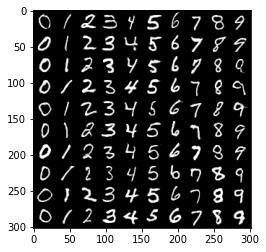

Iter: 09210/15000, Gen loss: 1.4047, Dis loss: 0.9330
Iter: 09220/15000, Gen loss: 1.4141, Dis loss: 0.5023
Iter: 09230/15000, Gen loss: 1.4517, Dis loss: 0.6714
Iter: 09240/15000, Gen loss: 2.1293, Dis loss: 0.8277
Iter: 09250/15000, Gen loss: 1.6868, Dis loss: 0.7601
Iter: 09260/15000, Gen loss: 1.3238, Dis loss: 0.6868
Iter: 09270/15000, Gen loss: 1.8002, Dis loss: 0.8073
Iter: 09280/15000, Gen loss: 1.8618, Dis loss: 0.4280
Iter: 09290/15000, Gen loss: 2.0691, Dis loss: 0.9545
Iter: 09300/15000, Gen loss: 1.7629, Dis loss: 0.9873
Iter: 09310/15000, Gen loss: 1.7606, Dis loss: 0.9498
Iter: 09320/15000, Gen loss: 1.9285, Dis loss: 1.0870
Iter: 09330/15000, Gen loss: 1.7368, Dis loss: 0.6903
Iter: 09340/15000, Gen loss: 0.7674, Dis loss: 0.6092
Iter: 09350/15000, Gen loss: 2.1809, Dis loss: 0.8104
Iter: 09360/15000, Gen loss: 1.4088, Dis loss: 0.6870
Iter: 09370/15000, Gen loss: 1.5044, Dis loss: 0.8806
Iter: 09380/15000, Gen loss: 1.2056, Dis loss: 0.8039
Iter: 09390/15000, Gen loss:

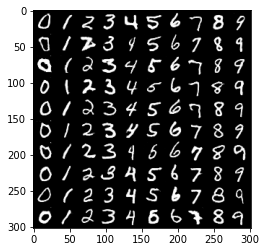

Iter: 09410/15000, Gen loss: 1.3557, Dis loss: 0.8331
Iter: 09420/15000, Gen loss: 1.3397, Dis loss: 0.8963
Iter: 09430/15000, Gen loss: 2.4688, Dis loss: 0.7341
Iter: 09440/15000, Gen loss: 1.5121, Dis loss: 0.5572
Iter: 09450/15000, Gen loss: 1.0868, Dis loss: 0.8192
Iter: 09460/15000, Gen loss: 1.9526, Dis loss: 0.7932
Iter: 09470/15000, Gen loss: 1.0307, Dis loss: 0.8655
Iter: 09480/15000, Gen loss: 0.9490, Dis loss: 1.0064
Iter: 09490/15000, Gen loss: 0.9900, Dis loss: 0.6779
Iter: 09500/15000, Gen loss: 1.8472, Dis loss: 1.0150
Iter: 09510/15000, Gen loss: 1.2769, Dis loss: 0.5966
Iter: 09520/15000, Gen loss: 1.3176, Dis loss: 0.7465
Iter: 09530/15000, Gen loss: 1.8813, Dis loss: 1.2030
Iter: 09540/15000, Gen loss: 1.5824, Dis loss: 0.7921
Iter: 09550/15000, Gen loss: 2.2990, Dis loss: 0.6137
Iter: 09560/15000, Gen loss: 1.2808, Dis loss: 0.9666
Iter: 09570/15000, Gen loss: 2.1865, Dis loss: 1.0816
Iter: 09580/15000, Gen loss: 1.5490, Dis loss: 1.0043
Iter: 09590/15000, Gen loss:

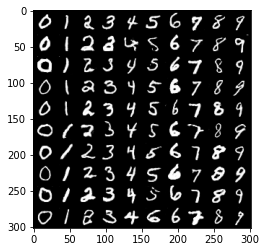

Iter: 09610/15000, Gen loss: 1.8134, Dis loss: 0.7473
Iter: 09620/15000, Gen loss: 0.6844, Dis loss: 0.7421
Iter: 09630/15000, Gen loss: 2.0629, Dis loss: 1.0365
Iter: 09640/15000, Gen loss: 0.7484, Dis loss: 1.3685
Iter: 09650/15000, Gen loss: 1.8045, Dis loss: 0.7614
Iter: 09660/15000, Gen loss: 1.7331, Dis loss: 1.3289
Iter: 09670/15000, Gen loss: 1.2985, Dis loss: 0.6945
Iter: 09680/15000, Gen loss: 1.4332, Dis loss: 0.9567
Iter: 09690/15000, Gen loss: 1.0490, Dis loss: 0.6882
Iter: 09700/15000, Gen loss: 1.4369, Dis loss: 1.4053
Iter: 09710/15000, Gen loss: 1.9427, Dis loss: 0.7101
Iter: 09720/15000, Gen loss: 1.2583, Dis loss: 0.8234
Iter: 09730/15000, Gen loss: 1.4875, Dis loss: 0.9948
Iter: 09740/15000, Gen loss: 1.6934, Dis loss: 0.6634
Iter: 09750/15000, Gen loss: 1.7070, Dis loss: 0.4817
Iter: 09760/15000, Gen loss: 0.8605, Dis loss: 1.1195
Iter: 09770/15000, Gen loss: 1.4140, Dis loss: 0.7079
Iter: 09780/15000, Gen loss: 1.5546, Dis loss: 0.8803
Iter: 09790/15000, Gen loss:

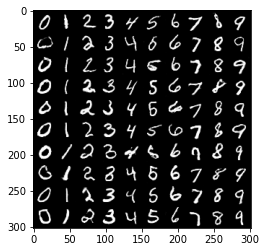

Iter: 09810/15000, Gen loss: 2.6031, Dis loss: 0.9226
Iter: 09820/15000, Gen loss: 2.5106, Dis loss: 1.4110
Iter: 09830/15000, Gen loss: 2.0193, Dis loss: 0.9299
Iter: 09840/15000, Gen loss: 1.1147, Dis loss: 1.0821
Iter: 09850/15000, Gen loss: 0.7516, Dis loss: 0.9840
Iter: 09860/15000, Gen loss: 1.4015, Dis loss: 0.6593
Iter: 09870/15000, Gen loss: 1.7226, Dis loss: 0.8389
Iter: 09880/15000, Gen loss: 1.6913, Dis loss: 0.6314
Iter: 09890/15000, Gen loss: 0.2628, Dis loss: 0.6282
Iter: 09900/15000, Gen loss: 1.5231, Dis loss: 1.1610
Iter: 09910/15000, Gen loss: 1.3125, Dis loss: 0.7606
Iter: 09920/15000, Gen loss: 2.4271, Dis loss: 1.2418
Iter: 09930/15000, Gen loss: 1.9987, Dis loss: 0.9516
Iter: 09940/15000, Gen loss: 1.3690, Dis loss: 0.5585
Iter: 09950/15000, Gen loss: 1.2117, Dis loss: 0.8376
Iter: 09960/15000, Gen loss: 2.0108, Dis loss: 1.0337
Iter: 09970/15000, Gen loss: 1.4517, Dis loss: 0.8026
Iter: 09980/15000, Gen loss: 2.0474, Dis loss: 1.4753
Iter: 09990/15000, Gen loss:

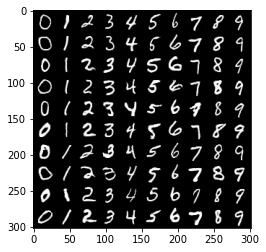

Iter: 10010/15000, Gen loss: 1.1684, Dis loss: 0.4372
Iter: 10020/15000, Gen loss: 2.7738, Dis loss: 0.6839
Iter: 10030/15000, Gen loss: 0.7975, Dis loss: 0.9617
Iter: 10040/15000, Gen loss: 0.4329, Dis loss: 1.0748
Iter: 10050/15000, Gen loss: 1.0005, Dis loss: 0.6967
Iter: 10060/15000, Gen loss: 2.5396, Dis loss: 0.6354
Iter: 10070/15000, Gen loss: 1.5054, Dis loss: 0.9585
Iter: 10080/15000, Gen loss: 1.3540, Dis loss: 0.9456
Iter: 10090/15000, Gen loss: 1.8063, Dis loss: 0.6567
Iter: 10100/15000, Gen loss: 1.2795, Dis loss: 0.7461
Iter: 10110/15000, Gen loss: 1.2286, Dis loss: 0.7398
Iter: 10120/15000, Gen loss: 1.1081, Dis loss: 0.9624
Iter: 10130/15000, Gen loss: 1.1916, Dis loss: 0.8802
Iter: 10140/15000, Gen loss: 2.2839, Dis loss: 0.8160
Iter: 10150/15000, Gen loss: 0.9383, Dis loss: 0.8765
Iter: 10160/15000, Gen loss: 1.5545, Dis loss: 1.1281
Iter: 10170/15000, Gen loss: 1.5268, Dis loss: 0.8594
Iter: 10180/15000, Gen loss: 1.8716, Dis loss: 0.9515
Iter: 10190/15000, Gen loss:

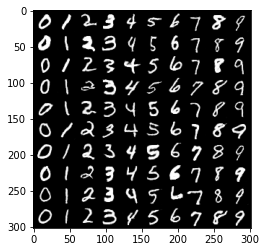

Iter: 10210/15000, Gen loss: 2.3469, Dis loss: 1.2538
Iter: 10220/15000, Gen loss: 1.5008, Dis loss: 0.5209
Iter: 10230/15000, Gen loss: 1.9570, Dis loss: 1.0096
Iter: 10240/15000, Gen loss: 0.4866, Dis loss: 0.7628
Iter: 10250/15000, Gen loss: 1.8999, Dis loss: 1.3610
Iter: 10260/15000, Gen loss: 0.6926, Dis loss: 1.3183
Iter: 10270/15000, Gen loss: 1.2455, Dis loss: 0.6729
Iter: 10280/15000, Gen loss: 2.4640, Dis loss: 1.0182
Iter: 10290/15000, Gen loss: 1.6367, Dis loss: 0.6784
Iter: 10300/15000, Gen loss: 2.1562, Dis loss: 0.8069
Iter: 10310/15000, Gen loss: 1.6069, Dis loss: 0.8326
Iter: 10320/15000, Gen loss: 0.5267, Dis loss: 1.4212
Iter: 10330/15000, Gen loss: 1.8325, Dis loss: 0.7971
Iter: 10340/15000, Gen loss: 1.6967, Dis loss: 0.7916
Iter: 10350/15000, Gen loss: 2.0825, Dis loss: 1.0929
Iter: 10360/15000, Gen loss: 1.9148, Dis loss: 0.6739
Iter: 10370/15000, Gen loss: 0.9655, Dis loss: 0.6599
Iter: 10380/15000, Gen loss: 1.4619, Dis loss: 0.5925
Iter: 10390/15000, Gen loss:

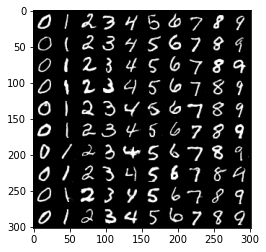

Iter: 10410/15000, Gen loss: 0.5933, Dis loss: 1.6026
Iter: 10420/15000, Gen loss: 1.3362, Dis loss: 0.9415
Iter: 10430/15000, Gen loss: 2.6554, Dis loss: 0.7661
Iter: 10440/15000, Gen loss: 1.9928, Dis loss: 0.6138
Iter: 10450/15000, Gen loss: 1.8594, Dis loss: 0.8061
Iter: 10460/15000, Gen loss: 1.2194, Dis loss: 0.7071
Iter: 10470/15000, Gen loss: 2.2096, Dis loss: 0.5347
Iter: 10480/15000, Gen loss: 1.5911, Dis loss: 0.8883
Iter: 10490/15000, Gen loss: 0.6871, Dis loss: 0.7380
Iter: 10500/15000, Gen loss: 1.5904, Dis loss: 0.7570
Iter: 10510/15000, Gen loss: 2.9554, Dis loss: 0.6813
Iter: 10520/15000, Gen loss: 1.0979, Dis loss: 0.7871
Iter: 10530/15000, Gen loss: 2.0997, Dis loss: 1.2442
Iter: 10540/15000, Gen loss: 2.4244, Dis loss: 0.6556
Iter: 10550/15000, Gen loss: 2.2018, Dis loss: 0.5830
Iter: 10560/15000, Gen loss: 1.3543, Dis loss: 0.7530
Iter: 10570/15000, Gen loss: 2.1314, Dis loss: 0.8033
Iter: 10580/15000, Gen loss: 1.6912, Dis loss: 1.1919
Iter: 10590/15000, Gen loss:

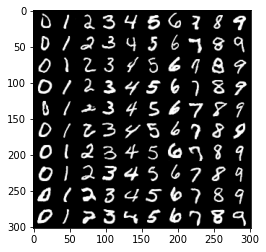

Iter: 10610/15000, Gen loss: 2.0184, Dis loss: 0.8125
Iter: 10620/15000, Gen loss: 1.6610, Dis loss: 0.6886
Iter: 10630/15000, Gen loss: 1.2182, Dis loss: 0.4583
Iter: 10640/15000, Gen loss: 1.2768, Dis loss: 0.5867
Iter: 10650/15000, Gen loss: 1.5821, Dis loss: 0.9641
Iter: 10660/15000, Gen loss: 2.5915, Dis loss: 0.8453
Iter: 10670/15000, Gen loss: 1.5125, Dis loss: 0.4307
Iter: 10680/15000, Gen loss: 2.3148, Dis loss: 0.6810
Iter: 10690/15000, Gen loss: 1.4726, Dis loss: 1.0674
Iter: 10700/15000, Gen loss: 1.8585, Dis loss: 0.6913
Iter: 10710/15000, Gen loss: 1.3829, Dis loss: 0.5487
Iter: 10720/15000, Gen loss: 2.3685, Dis loss: 0.8026
Iter: 10730/15000, Gen loss: 1.7734, Dis loss: 0.7942
Iter: 10740/15000, Gen loss: 1.4922, Dis loss: 0.5456
Iter: 10750/15000, Gen loss: 2.1708, Dis loss: 0.5735
Iter: 10760/15000, Gen loss: 1.3937, Dis loss: 0.8954
Iter: 10770/15000, Gen loss: 1.2184, Dis loss: 0.8110
Iter: 10780/15000, Gen loss: 2.0367, Dis loss: 1.4091
Iter: 10790/15000, Gen loss:

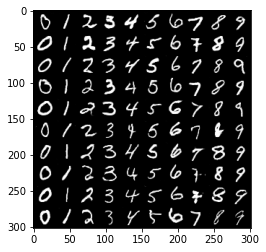

Iter: 10810/15000, Gen loss: 1.6701, Dis loss: 1.1948
Iter: 10820/15000, Gen loss: 2.1407, Dis loss: 0.9151
Iter: 10830/15000, Gen loss: 1.2611, Dis loss: 1.0097
Iter: 10840/15000, Gen loss: 1.1111, Dis loss: 0.7258
Iter: 10850/15000, Gen loss: 1.8835, Dis loss: 0.7886
Iter: 10860/15000, Gen loss: 1.7221, Dis loss: 1.2429
Iter: 10870/15000, Gen loss: 2.0002, Dis loss: 0.6360
Iter: 10880/15000, Gen loss: 1.2108, Dis loss: 0.7442
Iter: 10890/15000, Gen loss: 0.9617, Dis loss: 0.9588
Iter: 10900/15000, Gen loss: 2.4514, Dis loss: 0.9739
Iter: 10910/15000, Gen loss: 1.2193, Dis loss: 0.7553
Iter: 10920/15000, Gen loss: 2.2140, Dis loss: 0.5700
Iter: 10930/15000, Gen loss: 1.0704, Dis loss: 0.9573
Iter: 10940/15000, Gen loss: 1.5650, Dis loss: 0.6128
Iter: 10950/15000, Gen loss: 2.6047, Dis loss: 1.0296
Iter: 10960/15000, Gen loss: 1.6128, Dis loss: 1.0074
Iter: 10970/15000, Gen loss: 0.8530, Dis loss: 0.5559
Iter: 10980/15000, Gen loss: 1.1193, Dis loss: 0.7817
Iter: 10990/15000, Gen loss:

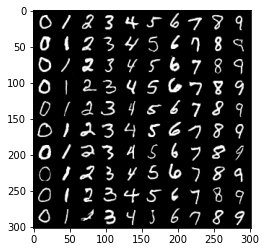

Iter: 11010/15000, Gen loss: 0.6477, Dis loss: 0.9186
Iter: 11020/15000, Gen loss: 1.8507, Dis loss: 0.6940
Iter: 11030/15000, Gen loss: 0.9470, Dis loss: 1.0171
Iter: 11040/15000, Gen loss: 1.3762, Dis loss: 1.3647
Iter: 11050/15000, Gen loss: 2.0659, Dis loss: 0.5050
Iter: 11060/15000, Gen loss: 1.3533, Dis loss: 1.3970
Iter: 11070/15000, Gen loss: 1.7163, Dis loss: 0.7463
Iter: 11080/15000, Gen loss: 1.6329, Dis loss: 0.7442
Iter: 11090/15000, Gen loss: 1.2889, Dis loss: 0.9627
Iter: 11100/15000, Gen loss: 2.1919, Dis loss: 0.5712
Iter: 11110/15000, Gen loss: 1.9120, Dis loss: 1.4248
Iter: 11120/15000, Gen loss: 1.4847, Dis loss: 0.9634
Iter: 11130/15000, Gen loss: 1.6750, Dis loss: 0.8474
Iter: 11140/15000, Gen loss: 1.9872, Dis loss: 0.4697
Iter: 11150/15000, Gen loss: 1.5685, Dis loss: 0.7101
Iter: 11160/15000, Gen loss: 2.3405, Dis loss: 1.2938
Iter: 11170/15000, Gen loss: 2.4037, Dis loss: 0.8352
Iter: 11180/15000, Gen loss: 2.0355, Dis loss: 1.5231
Iter: 11190/15000, Gen loss:

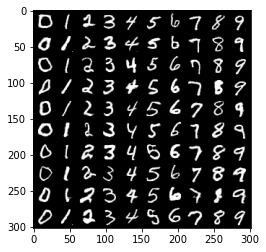

Iter: 11210/15000, Gen loss: 2.0973, Dis loss: 0.6437
Iter: 11220/15000, Gen loss: 2.3847, Dis loss: 0.9574
Iter: 11230/15000, Gen loss: 1.8367, Dis loss: 0.5806
Iter: 11240/15000, Gen loss: 1.9050, Dis loss: 0.5779
Iter: 11250/15000, Gen loss: 1.4759, Dis loss: 0.7736
Iter: 11260/15000, Gen loss: 2.0508, Dis loss: 0.4129
Iter: 11270/15000, Gen loss: 1.1519, Dis loss: 0.5966
Iter: 11280/15000, Gen loss: 1.8778, Dis loss: 0.9612
Iter: 11290/15000, Gen loss: 1.9637, Dis loss: 1.0967
Iter: 11300/15000, Gen loss: 1.4552, Dis loss: 0.5062
Iter: 11310/15000, Gen loss: 2.1377, Dis loss: 0.6095
Iter: 11320/15000, Gen loss: 1.4162, Dis loss: 0.7524
Iter: 11330/15000, Gen loss: 1.4442, Dis loss: 0.8173
Iter: 11340/15000, Gen loss: 1.4185, Dis loss: 0.6802
Iter: 11350/15000, Gen loss: 0.7367, Dis loss: 0.8410
Iter: 11360/15000, Gen loss: 1.9241, Dis loss: 0.9193
Iter: 11370/15000, Gen loss: 1.1680, Dis loss: 0.6292
Iter: 11380/15000, Gen loss: 2.5895, Dis loss: 1.1036
Iter: 11390/15000, Gen loss:

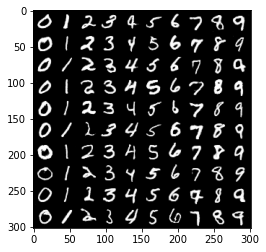

Iter: 11410/15000, Gen loss: 1.2580, Dis loss: 0.8479
Iter: 11420/15000, Gen loss: 1.0975, Dis loss: 1.0519
Iter: 11430/15000, Gen loss: 2.4421, Dis loss: 0.8712
Iter: 11440/15000, Gen loss: 0.8369, Dis loss: 0.8809
Iter: 11450/15000, Gen loss: 2.8048, Dis loss: 0.6734
Iter: 11460/15000, Gen loss: 1.9868, Dis loss: 0.6102
Iter: 11470/15000, Gen loss: 1.2090, Dis loss: 0.4335
Iter: 11480/15000, Gen loss: 2.3758, Dis loss: 0.4938
Iter: 11490/15000, Gen loss: 0.5124, Dis loss: 0.7175
Iter: 11500/15000, Gen loss: 2.5895, Dis loss: 0.7616
Iter: 11510/15000, Gen loss: 1.4687, Dis loss: 0.5404
Iter: 11520/15000, Gen loss: 2.1353, Dis loss: 0.7307
Iter: 11530/15000, Gen loss: 1.7751, Dis loss: 1.0714
Iter: 11540/15000, Gen loss: 1.0383, Dis loss: 0.6471
Iter: 11550/15000, Gen loss: 1.2274, Dis loss: 1.0515
Iter: 11560/15000, Gen loss: 3.4594, Dis loss: 0.8000
Iter: 11570/15000, Gen loss: 1.7132, Dis loss: 0.9963
Iter: 11580/15000, Gen loss: 2.1242, Dis loss: 0.4863
Iter: 11590/15000, Gen loss:

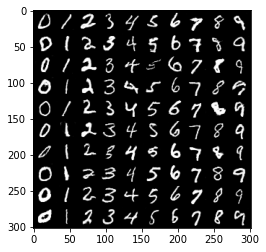

Iter: 11610/15000, Gen loss: 1.5950, Dis loss: 0.6060
Iter: 11620/15000, Gen loss: 1.6498, Dis loss: 0.7758
Iter: 11630/15000, Gen loss: 1.0398, Dis loss: 0.9171
Iter: 11640/15000, Gen loss: 2.1716, Dis loss: 0.9999
Iter: 11650/15000, Gen loss: 1.6798, Dis loss: 0.8647
Iter: 11660/15000, Gen loss: 1.0398, Dis loss: 0.6571
Iter: 11670/15000, Gen loss: 2.0557, Dis loss: 0.7282
Iter: 11680/15000, Gen loss: 2.0155, Dis loss: 0.8031
Iter: 11690/15000, Gen loss: 1.8982, Dis loss: 0.9696
Iter: 11700/15000, Gen loss: 0.8842, Dis loss: 1.1911
Iter: 11710/15000, Gen loss: 0.8935, Dis loss: 1.2486
Iter: 11720/15000, Gen loss: 3.1707, Dis loss: 0.6416
Iter: 11730/15000, Gen loss: 2.3424, Dis loss: 0.6102
Iter: 11740/15000, Gen loss: 1.8189, Dis loss: 0.9446
Iter: 11750/15000, Gen loss: 1.8072, Dis loss: 1.6616
Iter: 11760/15000, Gen loss: 1.5315, Dis loss: 0.5967
Iter: 11770/15000, Gen loss: 1.2849, Dis loss: 0.7425
Iter: 11780/15000, Gen loss: 1.6966, Dis loss: 1.1815
Iter: 11790/15000, Gen loss:

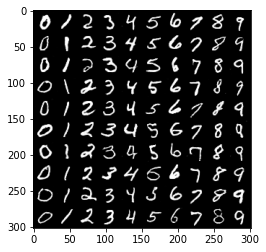

Iter: 11810/15000, Gen loss: 1.3958, Dis loss: 1.2659
Iter: 11820/15000, Gen loss: 1.1015, Dis loss: 0.5725
Iter: 11830/15000, Gen loss: 1.8226, Dis loss: 0.8441
Iter: 11840/15000, Gen loss: 2.2812, Dis loss: 0.7704
Iter: 11850/15000, Gen loss: 1.0607, Dis loss: 1.2623
Iter: 11860/15000, Gen loss: 1.7782, Dis loss: 0.6110
Iter: 11870/15000, Gen loss: 0.8562, Dis loss: 0.9761
Iter: 11880/15000, Gen loss: 1.0773, Dis loss: 0.8771
Iter: 11890/15000, Gen loss: 1.5014, Dis loss: 0.8293
Iter: 11900/15000, Gen loss: 1.4307, Dis loss: 0.5211
Iter: 11910/15000, Gen loss: 1.2854, Dis loss: 0.8825
Iter: 11920/15000, Gen loss: 1.6576, Dis loss: 1.1333
Iter: 11930/15000, Gen loss: 1.6055, Dis loss: 0.5366
Iter: 11940/15000, Gen loss: 1.7600, Dis loss: 0.5632
Iter: 11950/15000, Gen loss: 1.2791, Dis loss: 0.7289
Iter: 11960/15000, Gen loss: 3.1278, Dis loss: 0.5479
Iter: 11970/15000, Gen loss: 1.1659, Dis loss: 0.5864
Iter: 11980/15000, Gen loss: 1.4798, Dis loss: 0.5426
Iter: 11990/15000, Gen loss:

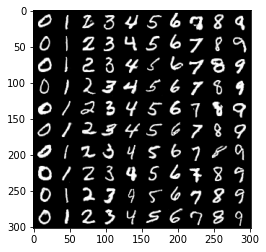

Iter: 12010/15000, Gen loss: 1.9278, Dis loss: 0.6909
Iter: 12020/15000, Gen loss: 1.4386, Dis loss: 1.1732
Iter: 12030/15000, Gen loss: 2.3512, Dis loss: 1.0012
Iter: 12040/15000, Gen loss: 1.7311, Dis loss: 0.6245
Iter: 12050/15000, Gen loss: 1.5078, Dis loss: 0.8284
Iter: 12060/15000, Gen loss: 1.7298, Dis loss: 1.1151
Iter: 12070/15000, Gen loss: 1.2200, Dis loss: 0.6832
Iter: 12080/15000, Gen loss: 2.1558, Dis loss: 0.9089
Iter: 12090/15000, Gen loss: 1.3352, Dis loss: 0.8027
Iter: 12100/15000, Gen loss: 1.3348, Dis loss: 0.7911
Iter: 12110/15000, Gen loss: 1.5352, Dis loss: 0.6368
Iter: 12120/15000, Gen loss: 1.2660, Dis loss: 0.5500
Iter: 12130/15000, Gen loss: 2.4771, Dis loss: 0.7658
Iter: 12140/15000, Gen loss: 0.6896, Dis loss: 0.8129
Iter: 12150/15000, Gen loss: 1.8266, Dis loss: 0.4364
Iter: 12160/15000, Gen loss: 1.7095, Dis loss: 0.7688
Iter: 12170/15000, Gen loss: 1.8190, Dis loss: 0.7566
Iter: 12180/15000, Gen loss: 2.1604, Dis loss: 1.0231
Iter: 12190/15000, Gen loss:

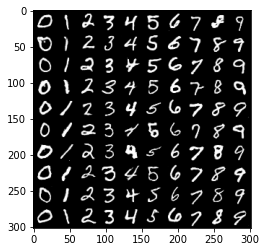

Iter: 12210/15000, Gen loss: 1.3543, Dis loss: 0.7829
Iter: 12220/15000, Gen loss: 1.0743, Dis loss: 0.5853
Iter: 12230/15000, Gen loss: 1.7953, Dis loss: 0.6185
Iter: 12240/15000, Gen loss: 2.1129, Dis loss: 0.7797
Iter: 12250/15000, Gen loss: 1.0500, Dis loss: 0.5209
Iter: 12260/15000, Gen loss: 1.9372, Dis loss: 0.5494
Iter: 12270/15000, Gen loss: 1.4122, Dis loss: 0.6384
Iter: 12280/15000, Gen loss: 1.5580, Dis loss: 0.7515
Iter: 12290/15000, Gen loss: 1.6412, Dis loss: 0.9940
Iter: 12300/15000, Gen loss: 1.3307, Dis loss: 0.5786
Iter: 12310/15000, Gen loss: 1.4207, Dis loss: 0.6231
Iter: 12320/15000, Gen loss: 2.6240, Dis loss: 0.5615
Iter: 12330/15000, Gen loss: 2.4288, Dis loss: 0.6568
Iter: 12340/15000, Gen loss: 0.8340, Dis loss: 0.5409
Iter: 12350/15000, Gen loss: 1.7871, Dis loss: 0.6656
Iter: 12360/15000, Gen loss: 1.3498, Dis loss: 0.6517
Iter: 12370/15000, Gen loss: 1.2137, Dis loss: 0.5295
Iter: 12380/15000, Gen loss: 2.6197, Dis loss: 0.8019
Iter: 12390/15000, Gen loss:

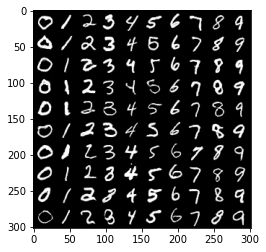

Iter: 12410/15000, Gen loss: 1.6730, Dis loss: 0.3014
Iter: 12420/15000, Gen loss: 1.1921, Dis loss: 1.3757
Iter: 12430/15000, Gen loss: 1.7281, Dis loss: 0.6693
Iter: 12440/15000, Gen loss: 2.7400, Dis loss: 1.0184
Iter: 12450/15000, Gen loss: 1.0018, Dis loss: 0.8418
Iter: 12460/15000, Gen loss: 2.3588, Dis loss: 0.7101
Iter: 12470/15000, Gen loss: 1.9621, Dis loss: 0.8022
Iter: 12480/15000, Gen loss: 1.9910, Dis loss: 0.5111
Iter: 12490/15000, Gen loss: 2.0778, Dis loss: 0.6226
Iter: 12500/15000, Gen loss: 2.4163, Dis loss: 0.5555
Iter: 12510/15000, Gen loss: 1.6893, Dis loss: 0.7159
Iter: 12520/15000, Gen loss: 2.0481, Dis loss: 0.5259
Iter: 12530/15000, Gen loss: 1.1359, Dis loss: 0.6803
Iter: 12540/15000, Gen loss: 1.9797, Dis loss: 0.4367
Iter: 12550/15000, Gen loss: 2.1643, Dis loss: 0.4122
Iter: 12560/15000, Gen loss: 1.6408, Dis loss: 0.9333
Iter: 12570/15000, Gen loss: 1.5898, Dis loss: 0.4335
Iter: 12580/15000, Gen loss: 0.9964, Dis loss: 0.9398
Iter: 12590/15000, Gen loss:

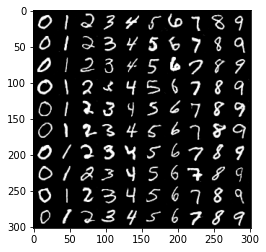

Iter: 12610/15000, Gen loss: 1.0281, Dis loss: 0.5873
Iter: 12620/15000, Gen loss: 2.2839, Dis loss: 0.7238
Iter: 12630/15000, Gen loss: 1.6340, Dis loss: 0.7776
Iter: 12640/15000, Gen loss: 1.9229, Dis loss: 0.5601
Iter: 12650/15000, Gen loss: 1.4223, Dis loss: 0.8562
Iter: 12660/15000, Gen loss: 2.1537, Dis loss: 0.6595
Iter: 12670/15000, Gen loss: 2.0380, Dis loss: 0.7169
Iter: 12680/15000, Gen loss: 1.7961, Dis loss: 0.4491
Iter: 12690/15000, Gen loss: 1.9048, Dis loss: 1.1925
Iter: 12700/15000, Gen loss: 1.5380, Dis loss: 0.5624
Iter: 12710/15000, Gen loss: 1.5918, Dis loss: 0.9907
Iter: 12720/15000, Gen loss: 3.1064, Dis loss: 0.5208
Iter: 12730/15000, Gen loss: 1.0133, Dis loss: 1.3917
Iter: 12740/15000, Gen loss: 2.3600, Dis loss: 0.5903
Iter: 12750/15000, Gen loss: 1.2561, Dis loss: 0.6120
Iter: 12760/15000, Gen loss: 1.5181, Dis loss: 0.7305
Iter: 12770/15000, Gen loss: 1.6149, Dis loss: 1.2621
Iter: 12780/15000, Gen loss: 1.5470, Dis loss: 0.7395
Iter: 12790/15000, Gen loss:

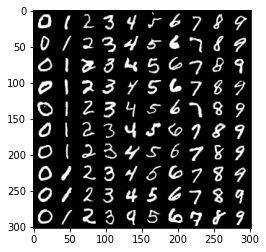

Iter: 12810/15000, Gen loss: 1.4477, Dis loss: 0.7652
Iter: 12820/15000, Gen loss: 1.6945, Dis loss: 0.6766
Iter: 12830/15000, Gen loss: 0.9922, Dis loss: 0.6301
Iter: 12840/15000, Gen loss: 2.3589, Dis loss: 0.8101
Iter: 12850/15000, Gen loss: 1.6823, Dis loss: 0.6100
Iter: 12860/15000, Gen loss: 1.8134, Dis loss: 0.9609
Iter: 12870/15000, Gen loss: 3.4385, Dis loss: 0.4996
Iter: 12880/15000, Gen loss: 2.0421, Dis loss: 0.6813
Iter: 12890/15000, Gen loss: 1.6242, Dis loss: 0.7788
Iter: 12900/15000, Gen loss: 2.5627, Dis loss: 1.0960
Iter: 12910/15000, Gen loss: 1.8774, Dis loss: 0.6169
Iter: 12920/15000, Gen loss: 3.0849, Dis loss: 0.4879
Iter: 12930/15000, Gen loss: 2.2239, Dis loss: 0.6073
Iter: 12940/15000, Gen loss: 2.3756, Dis loss: 1.0307
Iter: 12950/15000, Gen loss: 2.0716, Dis loss: 0.4110
Iter: 12960/15000, Gen loss: 2.4454, Dis loss: 0.8726
Iter: 12970/15000, Gen loss: 1.8822, Dis loss: 0.4429
Iter: 12980/15000, Gen loss: 2.6128, Dis loss: 0.5816
Iter: 12990/15000, Gen loss:

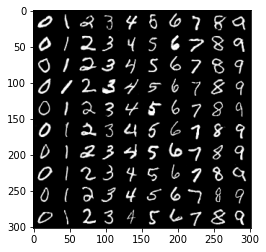

Iter: 13010/15000, Gen loss: 1.1336, Dis loss: 0.8318
Iter: 13020/15000, Gen loss: 1.8101, Dis loss: 0.6219
Iter: 13030/15000, Gen loss: 1.6859, Dis loss: 0.7702
Iter: 13040/15000, Gen loss: 2.6721, Dis loss: 0.6849
Iter: 13050/15000, Gen loss: 0.8974, Dis loss: 0.6207
Iter: 13060/15000, Gen loss: 0.7374, Dis loss: 0.8509
Iter: 13070/15000, Gen loss: 2.6832, Dis loss: 0.8927
Iter: 13080/15000, Gen loss: 3.3422, Dis loss: 0.8605
Iter: 13090/15000, Gen loss: 1.0227, Dis loss: 0.7534
Iter: 13100/15000, Gen loss: 1.8883, Dis loss: 0.5190
Iter: 13110/15000, Gen loss: 0.9683, Dis loss: 0.5721
Iter: 13120/15000, Gen loss: 1.6869, Dis loss: 0.9498
Iter: 13130/15000, Gen loss: 0.8988, Dis loss: 1.2867
Iter: 13140/15000, Gen loss: 1.8235, Dis loss: 0.7376
Iter: 13150/15000, Gen loss: 2.6670, Dis loss: 0.5870
Iter: 13160/15000, Gen loss: 1.6245, Dis loss: 0.5155
Iter: 13170/15000, Gen loss: 2.1021, Dis loss: 0.6001
Iter: 13180/15000, Gen loss: 0.7726, Dis loss: 0.4813
Iter: 13190/15000, Gen loss:

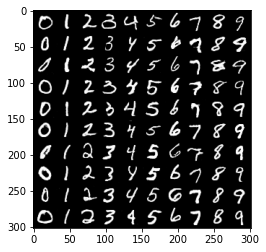

Iter: 13210/15000, Gen loss: 1.9633, Dis loss: 0.9153
Iter: 13220/15000, Gen loss: 0.8902, Dis loss: 0.9750
Iter: 13230/15000, Gen loss: 2.6391, Dis loss: 0.5766
Iter: 13240/15000, Gen loss: 1.8962, Dis loss: 0.3916
Iter: 13250/15000, Gen loss: 2.8615, Dis loss: 0.6923
Iter: 13260/15000, Gen loss: 1.1916, Dis loss: 0.8003
Iter: 13270/15000, Gen loss: 1.8485, Dis loss: 0.6685
Iter: 13280/15000, Gen loss: 2.3828, Dis loss: 0.4630
Iter: 13290/15000, Gen loss: 2.6838, Dis loss: 0.6954
Iter: 13300/15000, Gen loss: 3.0222, Dis loss: 0.5288
Iter: 13310/15000, Gen loss: 1.4782, Dis loss: 1.1016
Iter: 13320/15000, Gen loss: 2.1031, Dis loss: 0.7276
Iter: 13330/15000, Gen loss: 2.0690, Dis loss: 0.5720
Iter: 13340/15000, Gen loss: 1.4737, Dis loss: 0.7064
Iter: 13350/15000, Gen loss: 2.5081, Dis loss: 0.3513
Iter: 13360/15000, Gen loss: 1.5662, Dis loss: 0.8153
Iter: 13370/15000, Gen loss: 2.8063, Dis loss: 0.6118
Iter: 13380/15000, Gen loss: 3.4990, Dis loss: 0.4075
Iter: 13390/15000, Gen loss:

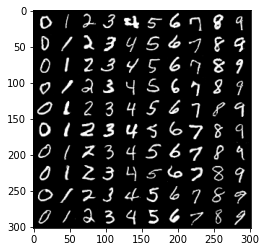

Iter: 13410/15000, Gen loss: 1.4186, Dis loss: 1.0542
Iter: 13420/15000, Gen loss: 1.4775, Dis loss: 0.6241
Iter: 13430/15000, Gen loss: 2.0301, Dis loss: 0.5782
Iter: 13440/15000, Gen loss: 1.1740, Dis loss: 0.4817
Iter: 13450/15000, Gen loss: 2.2927, Dis loss: 0.8239
Iter: 13460/15000, Gen loss: 1.2207, Dis loss: 0.7579
Iter: 13470/15000, Gen loss: 2.6247, Dis loss: 0.2516
Iter: 13480/15000, Gen loss: 2.0938, Dis loss: 0.9427
Iter: 13490/15000, Gen loss: 1.1654, Dis loss: 0.8506
Iter: 13500/15000, Gen loss: 2.1894, Dis loss: 0.5530
Iter: 13510/15000, Gen loss: 1.6273, Dis loss: 0.4881
Iter: 13520/15000, Gen loss: 2.7684, Dis loss: 0.4892
Iter: 13530/15000, Gen loss: 1.1986, Dis loss: 0.5379
Iter: 13540/15000, Gen loss: 3.9257, Dis loss: 0.8296
Iter: 13550/15000, Gen loss: 1.7302, Dis loss: 0.8552
Iter: 13560/15000, Gen loss: 1.1095, Dis loss: 0.7600
Iter: 13570/15000, Gen loss: 3.0770, Dis loss: 0.3158
Iter: 13580/15000, Gen loss: 3.3544, Dis loss: 1.0329
Iter: 13590/15000, Gen loss:

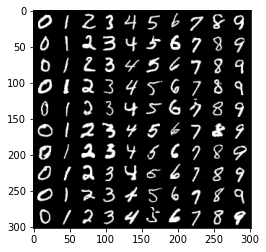

Iter: 13610/15000, Gen loss: 1.8298, Dis loss: 0.6461
Iter: 13620/15000, Gen loss: 1.4191, Dis loss: 0.4978
Iter: 13630/15000, Gen loss: 0.8454, Dis loss: 0.5496
Iter: 13640/15000, Gen loss: 2.6076, Dis loss: 0.6688
Iter: 13650/15000, Gen loss: 1.7164, Dis loss: 0.7497
Iter: 13660/15000, Gen loss: 2.2238, Dis loss: 0.6038
Iter: 13670/15000, Gen loss: 1.2431, Dis loss: 0.7738
Iter: 13680/15000, Gen loss: 2.8803, Dis loss: 0.4776
Iter: 13690/15000, Gen loss: 2.2894, Dis loss: 0.7208
Iter: 13700/15000, Gen loss: 2.7517, Dis loss: 0.6801
Iter: 13710/15000, Gen loss: 1.3534, Dis loss: 0.8994
Iter: 13720/15000, Gen loss: 2.2015, Dis loss: 0.4091
Iter: 13730/15000, Gen loss: 1.8502, Dis loss: 0.9205
Iter: 13740/15000, Gen loss: 1.4542, Dis loss: 0.7033
Iter: 13750/15000, Gen loss: 2.5612, Dis loss: 0.6432
Iter: 13760/15000, Gen loss: 1.8044, Dis loss: 0.8154
Iter: 13770/15000, Gen loss: 2.1539, Dis loss: 0.6905
Iter: 13780/15000, Gen loss: 3.1495, Dis loss: 0.6429
Iter: 13790/15000, Gen loss:

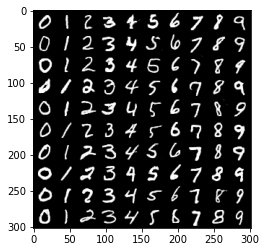

Iter: 13810/15000, Gen loss: 1.4299, Dis loss: 0.6691
Iter: 13820/15000, Gen loss: 3.3006, Dis loss: 0.3696
Iter: 13830/15000, Gen loss: 1.5065, Dis loss: 0.7301
Iter: 13840/15000, Gen loss: 1.5639, Dis loss: 0.8691
Iter: 13850/15000, Gen loss: 1.1211, Dis loss: 0.6307
Iter: 13860/15000, Gen loss: 1.8616, Dis loss: 0.8163
Iter: 13870/15000, Gen loss: 1.8388, Dis loss: 0.9299
Iter: 13880/15000, Gen loss: 2.6894, Dis loss: 1.3756
Iter: 13890/15000, Gen loss: 0.5447, Dis loss: 0.6909
Iter: 13900/15000, Gen loss: 1.2271, Dis loss: 0.9320
Iter: 13910/15000, Gen loss: 2.0128, Dis loss: 0.4847
Iter: 13920/15000, Gen loss: 2.1512, Dis loss: 0.4613
Iter: 13930/15000, Gen loss: 1.7405, Dis loss: 0.7268
Iter: 13940/15000, Gen loss: 1.5233, Dis loss: 1.4214
Iter: 13950/15000, Gen loss: 1.7715, Dis loss: 0.5922
Iter: 13960/15000, Gen loss: 1.9475, Dis loss: 0.6782
Iter: 13970/15000, Gen loss: 2.2337, Dis loss: 0.8116
Iter: 13980/15000, Gen loss: 1.9380, Dis loss: 0.4572
Iter: 13990/15000, Gen loss:

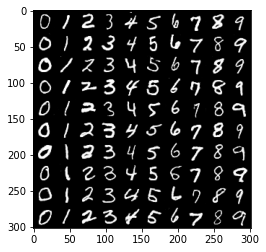

Iter: 14010/15000, Gen loss: 3.0492, Dis loss: 0.6885
Iter: 14020/15000, Gen loss: 1.3968, Dis loss: 0.6660
Iter: 14030/15000, Gen loss: 1.5047, Dis loss: 1.2436
Iter: 14040/15000, Gen loss: 1.5081, Dis loss: 0.2630
Iter: 14050/15000, Gen loss: 1.4292, Dis loss: 0.6260
Iter: 14060/15000, Gen loss: 1.3727, Dis loss: 0.3940
Iter: 14070/15000, Gen loss: 2.4868, Dis loss: 0.4016
Iter: 14080/15000, Gen loss: 0.4445, Dis loss: 0.3246
Iter: 14090/15000, Gen loss: 3.4255, Dis loss: 0.5393
Iter: 14100/15000, Gen loss: 1.0896, Dis loss: 0.4930
Iter: 14110/15000, Gen loss: 1.3042, Dis loss: 0.4292
Iter: 14120/15000, Gen loss: 2.0022, Dis loss: 0.3591
Iter: 14130/15000, Gen loss: 1.2336, Dis loss: 0.6792
Iter: 14140/15000, Gen loss: 2.7011, Dis loss: 0.3483
Iter: 14150/15000, Gen loss: 2.6177, Dis loss: 0.4694
Iter: 14160/15000, Gen loss: 2.0080, Dis loss: 0.6066
Iter: 14170/15000, Gen loss: 1.4260, Dis loss: 0.3400
Iter: 14180/15000, Gen loss: 1.9073, Dis loss: 1.1787
Iter: 14190/15000, Gen loss:

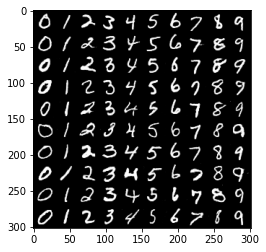

Iter: 14210/15000, Gen loss: 3.1343, Dis loss: 0.7485
Iter: 14220/15000, Gen loss: 2.3800, Dis loss: 0.6615
Iter: 14230/15000, Gen loss: 1.7347, Dis loss: 0.5295
Iter: 14240/15000, Gen loss: 3.0921, Dis loss: 0.3963
Iter: 14250/15000, Gen loss: 0.8253, Dis loss: 0.3945
Iter: 14260/15000, Gen loss: 2.3680, Dis loss: 0.3658
Iter: 14270/15000, Gen loss: 2.2364, Dis loss: 0.6118
Iter: 14280/15000, Gen loss: 1.2618, Dis loss: 0.3221
Iter: 14290/15000, Gen loss: 2.0257, Dis loss: 0.4669
Iter: 14300/15000, Gen loss: 1.5764, Dis loss: 0.7557
Iter: 14310/15000, Gen loss: 1.6119, Dis loss: 0.6612
Iter: 14320/15000, Gen loss: 0.8422, Dis loss: 0.3340
Iter: 14330/15000, Gen loss: 3.1820, Dis loss: 0.5481
Iter: 14340/15000, Gen loss: 1.4216, Dis loss: 0.5026
Iter: 14350/15000, Gen loss: 2.9872, Dis loss: 0.6419
Iter: 14360/15000, Gen loss: 2.0122, Dis loss: 0.7315
Iter: 14370/15000, Gen loss: 1.9386, Dis loss: 0.4155
Iter: 14380/15000, Gen loss: 1.5347, Dis loss: 0.8251
Iter: 14390/15000, Gen loss:

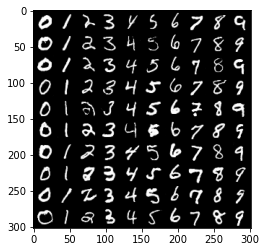

Iter: 14410/15000, Gen loss: 2.7904, Dis loss: 0.6605
Iter: 14420/15000, Gen loss: 1.5683, Dis loss: 1.2837
Iter: 14430/15000, Gen loss: 2.0048, Dis loss: 0.4084
Iter: 14440/15000, Gen loss: 1.7594, Dis loss: 0.8001
Iter: 14450/15000, Gen loss: 2.6637, Dis loss: 0.6074
Iter: 14460/15000, Gen loss: 1.0989, Dis loss: 0.5591
Iter: 14470/15000, Gen loss: 1.6598, Dis loss: 0.3697
Iter: 14480/15000, Gen loss: 1.5507, Dis loss: 0.3705
Iter: 14490/15000, Gen loss: 1.9699, Dis loss: 0.8666
Iter: 14500/15000, Gen loss: 2.6831, Dis loss: 0.7055
Iter: 14510/15000, Gen loss: 2.1596, Dis loss: 0.7317
Iter: 14520/15000, Gen loss: 3.0043, Dis loss: 0.8198
Iter: 14530/15000, Gen loss: 1.4552, Dis loss: 0.3587
Iter: 14540/15000, Gen loss: 1.9519, Dis loss: 0.4226
Iter: 14550/15000, Gen loss: 1.2080, Dis loss: 0.4679
Iter: 14560/15000, Gen loss: 1.7694, Dis loss: 0.5802
Iter: 14570/15000, Gen loss: 3.8862, Dis loss: 0.8232
Iter: 14580/15000, Gen loss: 2.3858, Dis loss: 0.9206
Iter: 14590/15000, Gen loss:

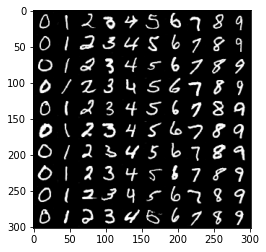

Iter: 14610/15000, Gen loss: 0.6680, Dis loss: 0.6514
Iter: 14620/15000, Gen loss: 1.3877, Dis loss: 0.7237
Iter: 14630/15000, Gen loss: 2.1332, Dis loss: 0.4558
Iter: 14640/15000, Gen loss: 1.4845, Dis loss: 0.5264
Iter: 14650/15000, Gen loss: 2.8002, Dis loss: 0.5733
Iter: 14660/15000, Gen loss: 1.4846, Dis loss: 0.5672
Iter: 14670/15000, Gen loss: 2.7819, Dis loss: 1.1603
Iter: 14680/15000, Gen loss: 1.5936, Dis loss: 0.5339
Iter: 14690/15000, Gen loss: 1.7382, Dis loss: 0.5666
Iter: 14700/15000, Gen loss: 1.5633, Dis loss: 0.3001
Iter: 14710/15000, Gen loss: 1.2859, Dis loss: 0.5377
Iter: 14720/15000, Gen loss: 2.7683, Dis loss: 0.4712
Iter: 14730/15000, Gen loss: 1.1676, Dis loss: 0.5789
Iter: 14740/15000, Gen loss: 1.9461, Dis loss: 0.6225
Iter: 14750/15000, Gen loss: 3.4491, Dis loss: 0.3308
Iter: 14760/15000, Gen loss: 0.6283, Dis loss: 0.5582
Iter: 14770/15000, Gen loss: 4.1974, Dis loss: 0.5445
Iter: 14780/15000, Gen loss: 2.3717, Dis loss: 0.4898
Iter: 14790/15000, Gen loss:

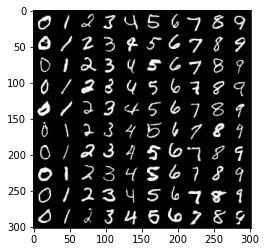

Iter: 14810/15000, Gen loss: 1.1105, Dis loss: 0.3575
Iter: 14820/15000, Gen loss: 2.6224, Dis loss: 0.3154
Iter: 14830/15000, Gen loss: 1.7974, Dis loss: 0.5029
Iter: 14840/15000, Gen loss: 2.0904, Dis loss: 0.5911
Iter: 14850/15000, Gen loss: 2.0318, Dis loss: 0.6783
Iter: 14860/15000, Gen loss: 2.8089, Dis loss: 0.4662
Iter: 14870/15000, Gen loss: 2.0378, Dis loss: 0.8130
Iter: 14880/15000, Gen loss: 2.9298, Dis loss: 0.4251
Iter: 14890/15000, Gen loss: 2.2634, Dis loss: 0.4530
Iter: 14900/15000, Gen loss: 0.6002, Dis loss: 0.4685
Iter: 14910/15000, Gen loss: 2.2220, Dis loss: 0.7810
Iter: 14920/15000, Gen loss: 1.7675, Dis loss: 0.6645
Iter: 14930/15000, Gen loss: 1.9438, Dis loss: 0.5734
Iter: 14940/15000, Gen loss: 3.6693, Dis loss: 0.5042
Iter: 14950/15000, Gen loss: 2.8327, Dis loss: 0.5611
Iter: 14960/15000, Gen loss: 1.8416, Dis loss: 0.8160
Iter: 14970/15000, Gen loss: 2.1636, Dis loss: 0.6675
Iter: 14980/15000, Gen loss: 1.6823, Dis loss: 0.3564
Iter: 14990/15000, Gen loss:

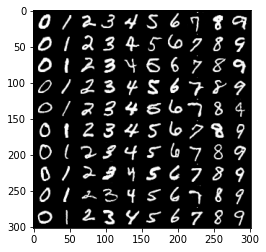

In [6]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_iter = iter(dataloader)

netG = Conditional_Generator(condition_dim, latent_dim, img_dim).to(device)
netD = Conditional_Discriminator(condition_dim, img_dim).to(device)

optimG = torch.optim.Adam(netG.parameters(), learning_rate)
optimD = torch.optim.Adam(netD.parameters(), learning_rate)

real_labels = torch.ones(batch_size).to(device)
fake_labels = torch.zeros(batch_size).to(device)

for it in range(total_iter):
    # train Discriminator
    for _ in range(1):
        try:
            real_imgs, real_conditions = next(dataloader_iter)
        except:
            dataloader_iter = iter(dataloader)
            real_imgs, real_conditions = next(dataloader_iter)

        real_imgs = real_imgs.to(device)
        real_conditions_onehot = torch.zeros((batch_size, condition_dim))
        real_conditions_onehot.scatter_(1, real_conditions.long().unsqueeze(-1), 1.)
        real_conditions_onehot = real_conditions_onehot.to(device)
        
        z = torch.randn((batch_size, latent_dim)).to(device)
        fake_conditions = torch.randint(0, condition_dim, (batch_size,))
        fake_conditions_onehot = torch.zeros((batch_size, condition_dim))
        fake_conditions_onehot.scatter_(1, fake_conditions.long().unsqueeze(-1), 1.)
        fake_conditions_onehot = fake_conditions_onehot.to(device)
        fake_imgs = netG(z, fake_conditions_onehot).detach()
        
        
        real_probs = netD(real_imgs, real_conditions_onehot).squeeze()
        fake_probs = netD(fake_imgs, fake_conditions_onehot).squeeze()
        
        ################ ToDo ################
        D_loss = -torch.mean(torch.log(real_probs)) - torch.mean(torch.log(1-fake_probs))
        
        optimD.zero_grad()
        D_loss.backward()
        optimD.step()
      
    # train the Generator
    z = torch.randn((batch_size, latent_dim)).to(device)
    fake_conditions = torch.randint(0, condition_dim, (batch_size,))
    fake_conditions_onehot = torch.zeros((batch_size, condition_dim))
    fake_conditions_onehot.scatter_(1, fake_conditions.long().unsqueeze(-1), 1.)
    fake_conditions_onehot = fake_conditions_onehot.to(device)
    fake_imgs = netG(z, fake_conditions_onehot)
        
    fake_probs = netD(fake_imgs, fake_conditions_onehot)
    
    ################ ToDo ################
    G_loss = -torch.mean(torch.log(fake_probs))
    
    optimG.zero_grad()
    G_loss.backward()
    optimG.step()
 
    
    if (it+1) % log_freq == 0:
        print("Iter: %05d/%d, Gen loss: %.4f, Dis loss: %.4f"%(it+1, total_iter,
                                                              G_loss.data.item(),
                                                              D_loss.data.item()))
    if (it+1) % viz_freq == 0:
        z = torch.randn((100, latent_dim)).to(device)
        gen_conditions_onehot = torch.zeros((100, condition_dim))
        gen_conditions_onehot.scatter_(1, gen_conditions.long().unsqueeze(-1), 1.)
        gen_conditions_onehot = gen_conditions_onehot.to(device)
        with torch.no_grad():
            gen_imgs = netG(z, gen_conditions_onehot)
        
        gen_imgs = make_grid(gen_imgs, nrow=10).permute(1, 2, 0).cpu().detach().numpy()
        plt.imshow(gen_imgs)
        plt.show()